### **Double-Threshold Validation Tool (DTVT)**

##### Code Author: Nicola Nocentini
##### Contacts: nicola.nocentini@unifi.it, nicola.nocentini@gmail.com
##### Date created: 11/03/2024

##### Description: the **Double-Threshold Validation Tool (DTVT)** is an automatic tool designed to validate pixel-based *Landslide Hazard Maps (LHMs)* and convert them in operational *Landslide Early Warning Systems (LEWSs)*. DTVT is based on a pair of thresholds used to classify a spatial unit (or *Pixel Aggregation Units (PAUs)*, e.g., a catchment) as unstable or not; which are:
##### -	*Failure Probability Threshold (FPT)*: the landslide probability value above which a pixel is considered unstable (e.g., ≥ 65%);
##### -	*Instability Diffusion Threshold (IDT)*: the amount of unstable pixels required to classify an entire PAU as unstable and to justify issuing a warning in that PAU (e.g., at least 5 pixels or 5% of the total pixels in the unit).
##### This approach also allows for establishing multiple warning criteria based on the FPT-IDT pair. By integrating DTVT into landslide hazard assessment workflows, decision-makers can effectively leverage LHMs for disaster risk reduction and emergency response.

====================================================================================================
#### **1) Libraries**
##### Install and import the necessary modules

In [ ]:
!pip install geopandas
!pip install rasterio
!pip install numpy
!pip install pandas
!pip install matplotlib


import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import rasterio
import warnings
from rasterio import mask
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib.legend_handler import HandlerPatch
from matplotlib.colors import Colormap

====================================================================================================
#### **2) LOAD THE INPUT DATA**

##### - Landslide Hazard Map (LHM): pixel-based map indicating the probability of landslides occurrence within a specific period of time and within a given area

##### - Pixel Aggregation Units (PAUs): polygonal shapefile representing territorial units chosen to spatially aggregate pixel-based LHMs. Possible PAUs could include catchment areas, slope units, municipalities, etc.

##### - Landslide Inventory: punctual or polygonal shapefile representing the database of landslides occurred during the modelled event.

In [2]:
# Indicate the date on which to perform the validation
validation_date = pd.to_datetime("16/05/2023", format='%d/%m/%Y')
print("Validation date:\n", validation_date)

Validation date:
 2023-05-16 00:00:00


In [ ]:
# Load the Pixel Aggregation Units (PAUs)
PAUs = gpd.read_file(r"insert_your_path\PAUs_exaple.shp")
print("PAUs CRS:\n", PAUs.crs)
PAUs

PAUs CRS:
 PROJCS["WGS_1984_Transverse_Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",42],PARAMETER["central_meridian",12.5],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


AREA   Code                                           geometry
0     5.316070    1.0  POLYGON ((-85145.276 248383.77, -84826.209 248...
1    43.393619    2.0  POLYGON ((-87519.592 244836.116, -87487.197 24...
2     5.910991    3.0  POLYGON ((-92405.799 245667.979, -92373.125 24...
3    11.878826    4.0  POLYGON ((-84162.688 244966.501, -84160.736 24...
4    15.997244    5.0  POLYGON ((-81205.716 242231.915, -81185.601 24...
..         ...    ...                                                ...
132   6.160250  133.0  POLYGON ((-94973.407 171636.747, -94956.505 17...
133   8.939836  134.0  POLYGON ((-129408.222 169159.179, -129378.324 ...
134  45.662533  135.0  POLYGON ((-104345.545 173634.068, -104328.464 ...
135  23.675722  136.0  POLYGON ((-128010.863 167724.73, -127986.014 1...
136  37.843825  137.0  POLYGON ((-110986.168 173212.04, -110899.493 1...

[137 rows x 3 columns]

In [ ]:
# Load the Landslides Inventory (to be commented for simulating an event without landslides)
landslides = gpd.read_file(r"insert_your_path\Landslides_exaple.shp") 
print("Landslides CRS:\n", landslides.crs)
if landslides.crs != PAUs.crs:
    landslides = landslides.to_crs(PAUs.crs)
    print("new Landslides CRS:\n", landslides.crs)

# Extract only the landslides that occurred on the validation date
landslides['DAY'] = pd.to_datetime(landslides['DAY'], format='%d/%m/%Y')
filtered_landslides = landslides[landslides['DAY'] == validation_date]
filtered_landslides

Landslides CRS:
 PROJCS["WGS_1984_Transverse_Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",42],PARAMETER["central_meridian",12.5],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


DAY           XUTM          YUTM                       geometry
6   2023-05-16  704973.847325  4.890370e+06  POINT (-75017.571 237923.461)
10  2023-05-16  694475.437690  4.898387e+06  POINT (-85165.118 246379.369)
50  2023-05-16  716765.248937  4.884578e+06  POINT (-63484.115 231635.809)
66  2023-05-16  702407.949908  4.891431e+06     POINT (-77535.92 239092.4)
73  2023-05-16  696402.020407  4.891463e+06      POINT (-83535 239379.749)
74  2023-05-16  714555.597610  4.886085e+06  POINT (-65627.462 233235.099)
80  2023-05-16  711530.851147  4.881297e+06  POINT (-68852.585 228580.688)
100 2023-05-16  709976.340995  4.883791e+06  POINT (-70299.642 231137.513)
102 2023-05-16  713766.491653  4.883748e+06  POINT (-66515.102 230933.471)
104 2023-05-16  694058.228859  4.898302e+06   POINT (-85585.553 246312.82)
105 2023-05-16  704860.752946  4.890402e+06  POINT (-75129.194 237960.296)
114 2023-05-16  704659.350526  4.890375e+06  POINT (-75331.565 237941.605)
129 2023-05-16  702811.343496  4.890382e+06  POINT (-77177.525 238027.332)
132 2023-05-16  693941.828804  4.898513e+06  POINT (-85692.896 246527.823)
136 2023-05-16  709418.995053  4.879075e+06  POINT (-71056.742 226449.855)
150 2023-05-16  711691.738150  4.878609e+06  POINT (-68806.015 225888.074)
161 2023-05-16  707837.412031  4.879131e+06  POINT (-72634.395 226573.249)
165 2023-05-16  718080.994121  4.886783e+06  POINT (-62076.048 233781.995)
167 2023-05-16  714333.732779  4.888472e+06  POINT (-65747.651 235628.501)
172 2023-05-16  704123.448978  4.887296e+06  POINT (-75997.921 234887.745)
177 2023-05-16  705532.006059  4.886252e+06  POINT (-74635.078 233784.992)
187 2023-05-16  718232.905935  4.887590e+06  POINT (-61889.962 234582.342)
205 2023-05-16  694646.046990  4.895467e+06  POINT (-85118.994 243455.022)
216 2023-05-16  714495.906993  4.867391e+06  POINT (-66480.449 214562.499)
221 2023-05-16  702250.393993  4.892142e+06   POINT (-77663.09 239809.139)
222 2023-05-16  700544.309903  4.890619e+06  POINT (-79432.392 238359.988)
223 2023-05-16  708557.315970  4.886683e+06   POINT (-71594.335 234087.76)
233 2023-05-16  693547.664335  4.893876e+06  POINT (-86284.161 241911.652)
235 2023-05-16  704077.730696  4.887494e+06  POINT (-76035.166 235087.763)
238 2023-05-16  698362.893595  4.892652e+06  POINT (-81525.293 240484.431)
245 2023-05-16  694034.672696  4.898280e+06  POINT (-85610.056 246291.134)
255 2023-05-16  702728.681347  4.890890e+06  POINT (-77238.519 238537.916)
260 2023-05-16  699764.564004  4.893375e+06    POINT (-80094.14 241146.98)
269 2023-05-16  692846.543695  4.893517e+06  POINT (-86999.913 241583.676)
270 2023-05-16  709465.290004  4.879140e+06   POINT (-71007.72 226513.115)
277 2023-05-16  710695.275275  4.887382e+06  POINT (-69428.774 234694.905)
305 2023-05-16  701757.450170  4.889173e+06  POINT (-78281.852 236864.383)
370 2023-05-16  707018.158699  4.892616e+06  POINT (-72879.673 240080.246)
373 2023-05-16  700716.610716  4.890285e+06  POINT (-79274.437 238019.466)
374 2023-05-16  705518.824743  4.886261e+06  POINT (-74647.863 233794.583)
423 2023-05-16  702289.429410  4.886220e+06  POINT (-77875.937 233891.274)
434 2023-05-16  704925.196398  4.890444e+06  POINT (-75063.048 237998.992)

Width: 842
Height: 870
Number of Bands: 1
Raster CRS:
 PROJCS["WGS_1984_Transverse_Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",42],PARAMETER["central_meridian",12.5],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Maximum value: 0.8988
Minimum value: -3.4028235e+38
Mean value: -inf


c:\Users\nicol\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


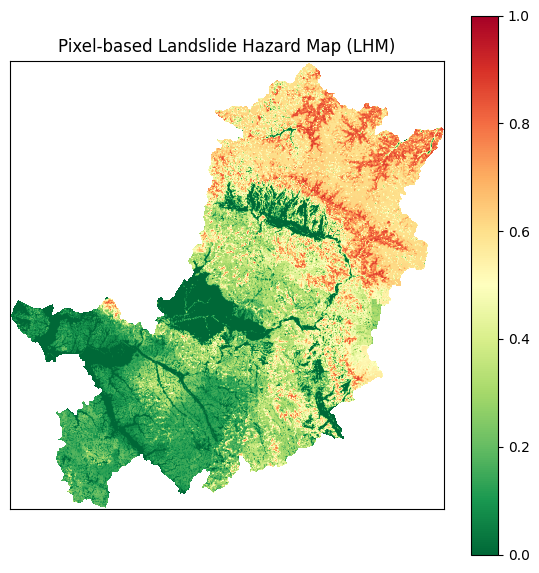

<Figure size 700x700 with 0 Axes>

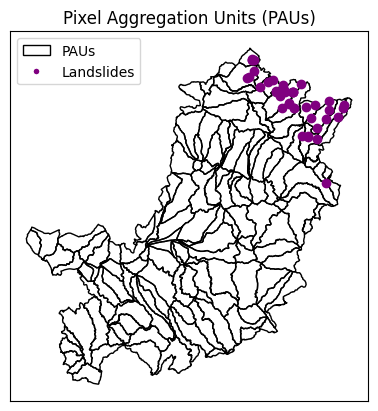

In [ ]:
# Load the pixel-based Landslide Hazard Map (LHM)
# Load only the LHM referred to the validation date
Raster = rasterio.open(r"insert_your_path\LHM_exaple.tif")
Prob = Raster.read(1)  # first band

# Accessing Raster attributes
print("Width:", Raster.width) # Number of rows
print("Height:", Raster.height) # Number of columns
print("Number of Bands:", Raster.count)  # Number of bands in the raster
print("Raster CRS:\n", Raster.crs)  # Coordinate reference system

# Check if the CRS of Raster matches PAUs, if not, reproject
if Raster.crs != PAUs.crs:
    # Calculate the transformation parameters
    transform, width, height = calculate_default_transform(
        Raster.crs, PAUs.crs, Raster.width, Raster.height, *Raster.bounds)
    # Update the metadata with the new CRS and transformation parameters
    kwargs = Raster.meta.copy()
    kwargs.update({
        'crs': PAUs.crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    # Create a new raster file with the projected data.
    with rasterio.open(r"insert_your_path\LHM_exaple_NEW.tif", 'w', **kwargs) as Proj_Raster:
        reproject(
            source=rasterio.band(Raster, 1),
            destination=rasterio.band(Proj_Raster, 1),
            src_transform=Raster.transform,
            src_crs=Raster.crs,
            dst_transform=transform,
            dst_crs=PAUs.crs,
            resampling=Resampling.nearest
        )
    # Load the projected raster data
    Raster=rasterio.open(r"insert_your_path\LHM_exaple_NEW.tif")
    Prob = Raster.read(1)  # first band
    print("new Raster CRS:\n", Raster.crs)
       
print("Maximum value:", np.nanmax(Prob)) # Maximum landslide probability value
print("Minimum value:", np.nanmin(Prob)) # Minimum landslide probability value
print("Mean value:", np.nanmean(Prob)) # Mean landslide probability value

# Plot the LHM
plt.figure(figsize=(7, 7))
Prob[Prob < 0] = np.nan
plt.imshow(Prob, cmap='RdYlGn_r', vmin=0, vmax=1, clim=[0, 1]) # Set minimum and maximum values that will be visualized with the colormap
plt.colorbar()  # Add a colorbar
plt.title('Pixel-based Landslide Hazard Map (LHM)')
plt.xticks([])
plt.yticks([])
plt.show()

# Plot the shapefiles
plt.figure(figsize=(7, 7))
ax=PAUs.plot(color="none", edgecolor="black")
plt.title('Pixel Aggregation Units (PAUs)')
plt.xticks([])
plt.yticks([])
bx=filtered_landslides.plot(ax=ax, color='purple')
# bx=landslides.plot(ax=ax, color='purple')
# Add legend
legend_PAUs = Patch(facecolor='white', edgecolor='black', label='PAUs')
legend_landslides = Line2D([0], [0], marker='o', color='w', markersize=5, markerfacecolor='purple',
                           markeredgewidth=1, label='Landslides')
plt.legend(handles=[legend_PAUs, legend_landslides], loc='upper left')
plt.show()

====================================================================================================
#### **3) Identify the PAUs that contain at least one landslide**

<Figure size 500x500 with 0 Axes>

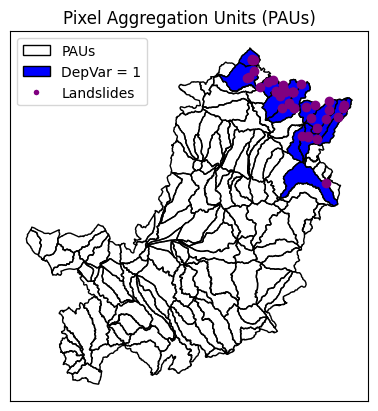

In [6]:
# PAUs['DepVar'] = 0 # For simulations of events without landslides (to be commented otherwise)

# For simulations of events with landslides (to be commented otherwise)
for f in range(len(PAUs)):
    for g in range(len(landslides)): # filtered_landslides
        in1 = filtered_landslides.geometry.intersects(PAUs.geometry.iloc[f])
        if in1.sum() > 0:
            PAUs.loc[f, 'DepVar'] = 1 # DepVar = Dependent Variable: 1 for presence and 0 for absence of landslides
        else:
            PAUs.loc[f, 'DepVar'] = 0
            

# Plot the DepVar
plt.figure(figsize=(5, 5))
ax=PAUs.plot(color="none", edgecolor="black")
plt.title('Pixel Aggregation Units (PAUs)')
filtered_PAUs = PAUs[PAUs['DepVar'] == 1]
legend_filtered = Patch(facecolor='blue', edgecolor='black', label='DepVar = 1')
cx=filtered_PAUs.plot(ax=ax, color="blue", edgecolor="black")
bx=filtered_landslides.plot(ax=ax, color='purple')
plt.xticks([])
plt.yticks([])
ax.legend(handles=[legend_PAUs, legend_filtered, legend_landslides], loc='upper left')
plt.show()

====================================================================================================
#### **4) Establish the FPT and IDT value ranges for DTVT iteration**

In [ ]:
# Insert your value of "start", "end" and "step" to initialize fpt and idt variables
fpt = np.arange(0.6, 0.80, 0.01)  # Failure Probability Threshold (FPT): it can be expressed in terms of landslide probability or safety factor
idt = np.arange(1, 20, 1)  # Instability Diffusion Threshold (IDT): it can be expressed in terms of number or percentage of pixels

print("Failure Probability Threshold (FPT):\n", fpt)
print('\n')
print("Instability Diffusion Threshold (IDT):\n", idt)

Failure Probability Threshold (FPT):
 [0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73
 0.74 0.75 0.76 0.77 0.78 0.79 0.8 ]


Instability Diffusion Threshold (IDT):
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


====================================================================================================
#### **5) Apply the DTVT**

##### - For each PAU, loop over FPT and IDT values
##### - Store the performance metrics in a contingency matrix for each iteration
##### - Plot the validation map
##### - Save the outputs (contingency matrix (.xlsx), validation map (.shp))

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

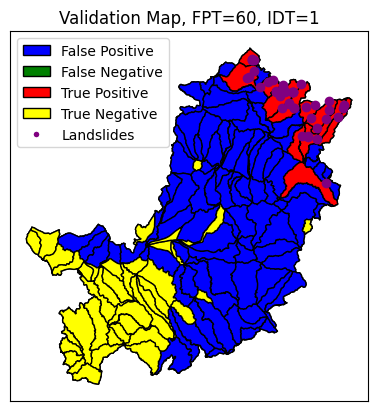

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

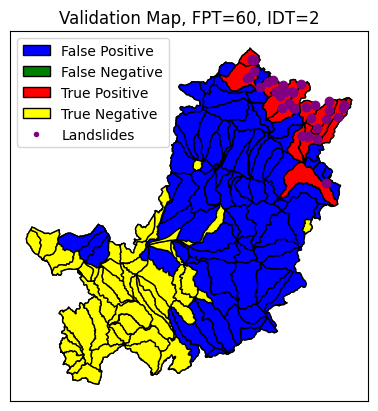

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

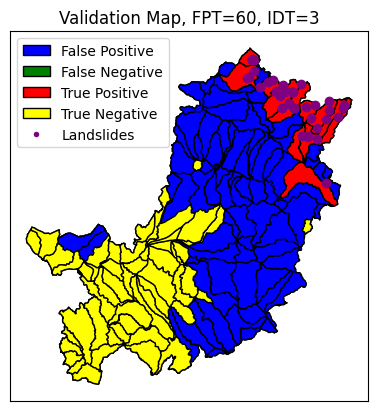

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

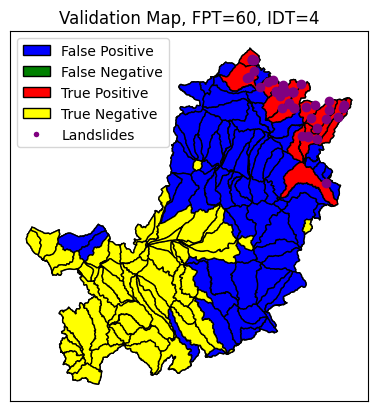

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

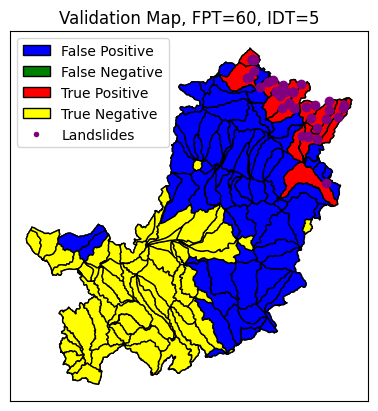

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

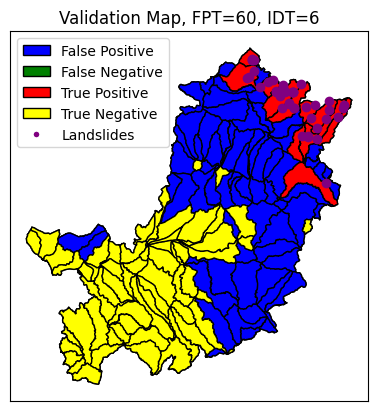

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

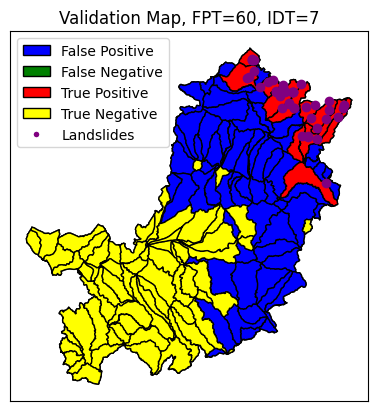

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

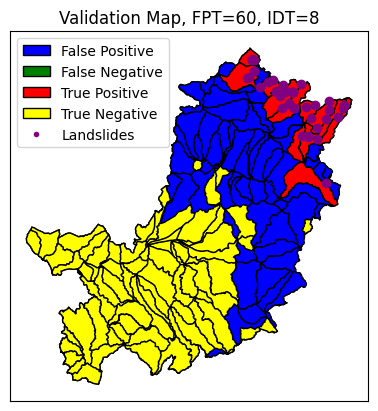

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

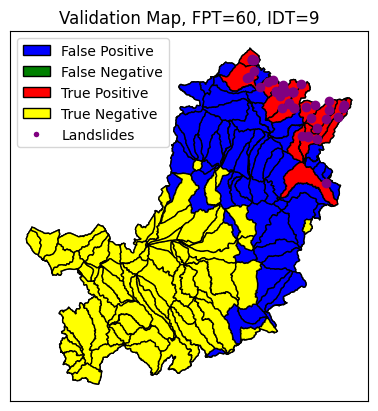

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

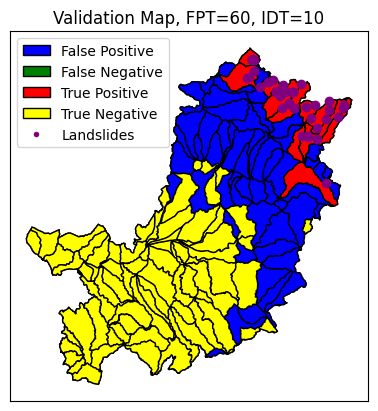

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

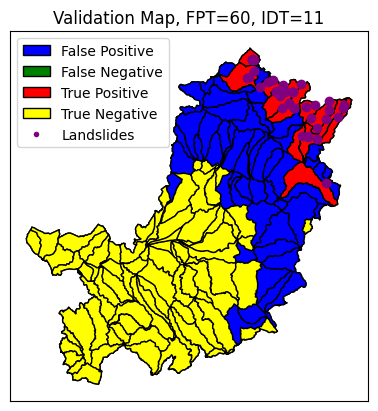

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

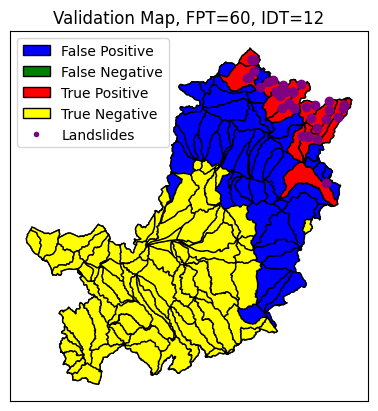

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

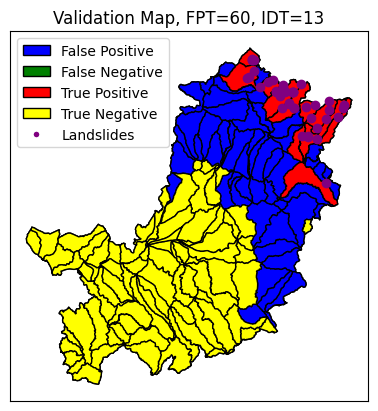

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

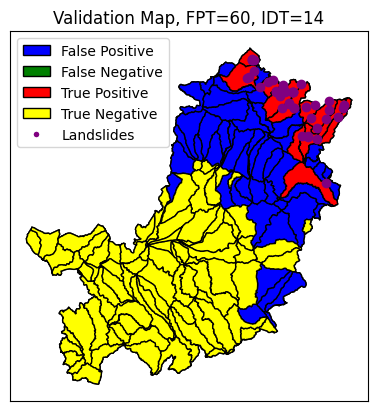

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

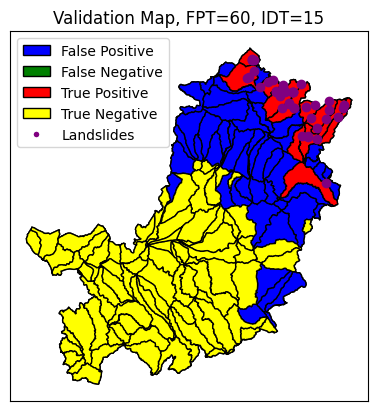

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

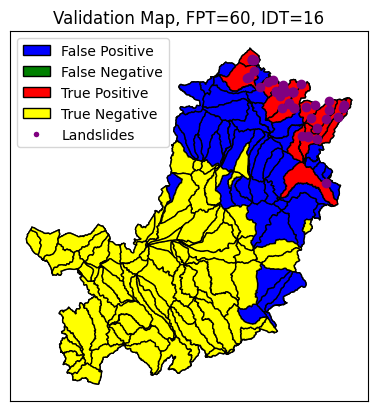

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

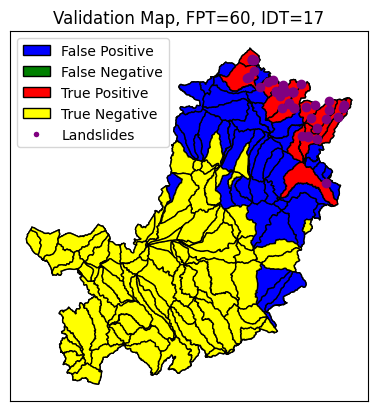

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

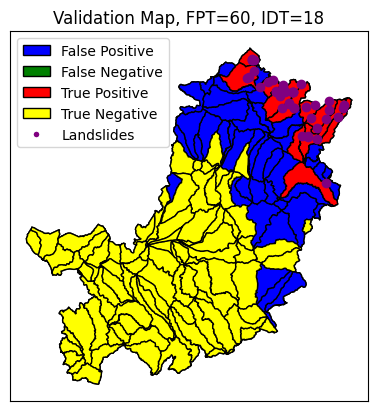

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

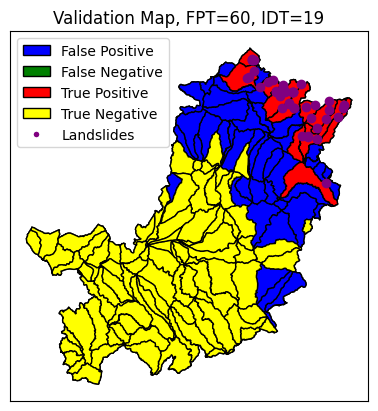

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

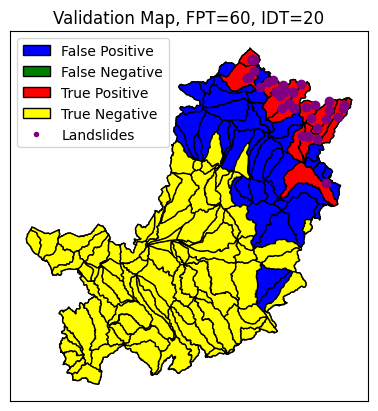

    FPT   IDT    TP   FN    FP    TN
0   0.6   1.0  12.0  0.0  86.0  39.0
1   0.6   2.0  12.0  0.0  80.0  45.0
2   0.6   3.0  12.0  0.0  74.0  51.0
3   0.6   4.0  12.0  0.0  69.0  56.0
4   0.6   5.0  12.0  0.0  68.0  57.0
5   0.6   6.0  12.0  0.0  66.0  59.0
6   0.6   7.0  12.0  0.0  63.0  62.0
7   0.6   8.0  12.0  0.0  59.0  66.0
8   0.6   9.0  12.0  0.0  57.0  68.0
9   0.6  10.0  12.0  0.0  56.0  69.0
10  0.6  11.0  12.0  0.0  53.0  72.0
11  0.6  12.0  12.0  0.0  51.0  74.0
12  0.6  13.0  12.0  0.0  51.0  74.0
13  0.6  14.0  12.0  0.0  48.0  77.0
14  0.6  15.0  12.0  0.0  48.0  77.0
15  0.6  16.0  12.0  0.0  46.0  79.0
16  0.6  17.0  12.0  0.0  44.0  81.0
17  0.6  18.0  12.0  0.0  43.0  82.0
18  0.6  19.0  12.0  0.0  43.0  82.0
19  0.6  20.0  12.0  0.0  41.0  84.0
--------------------------------------------------


C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

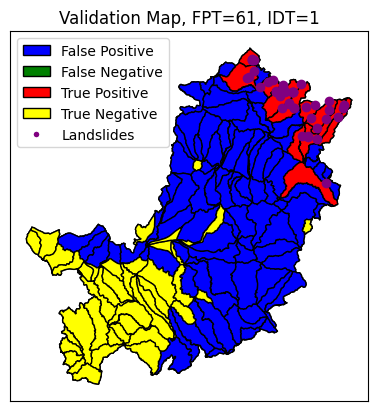

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

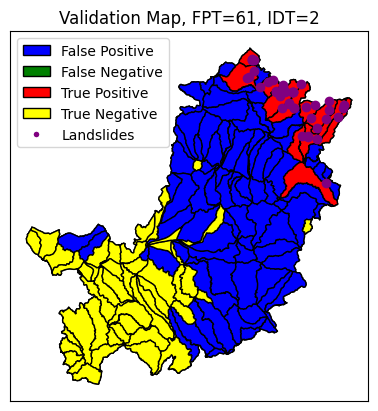

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

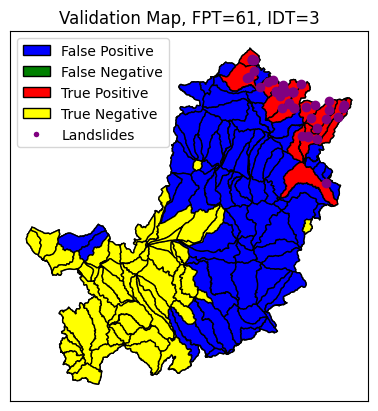

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

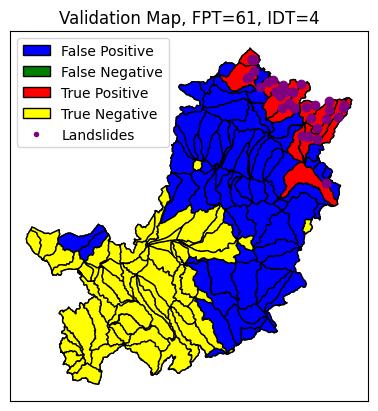

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

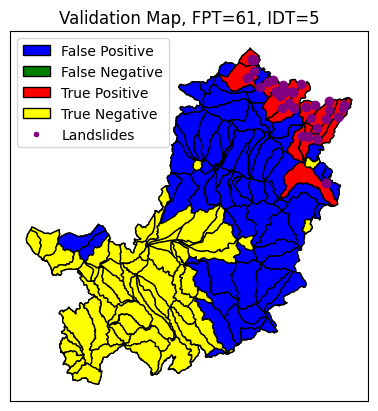

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

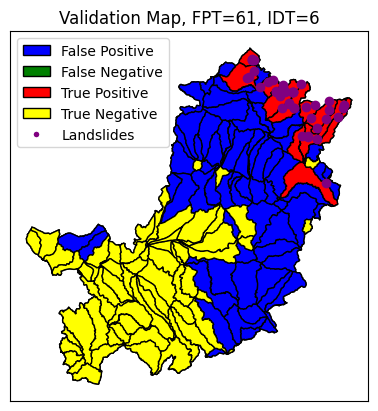

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

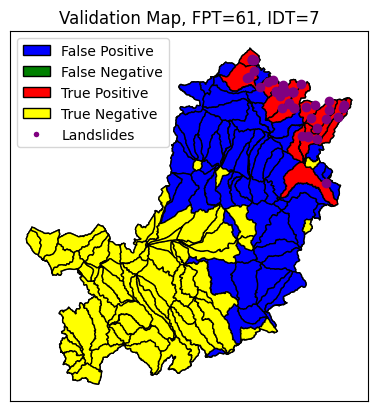

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

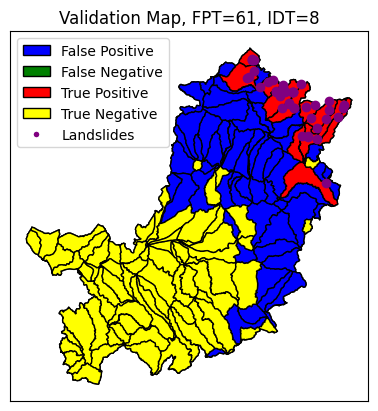

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

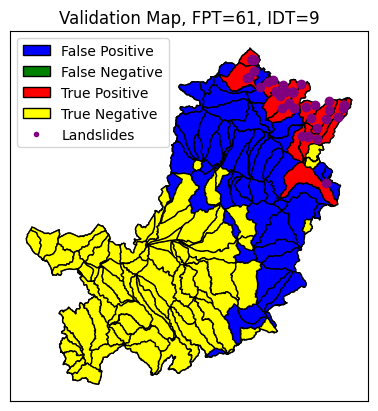

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

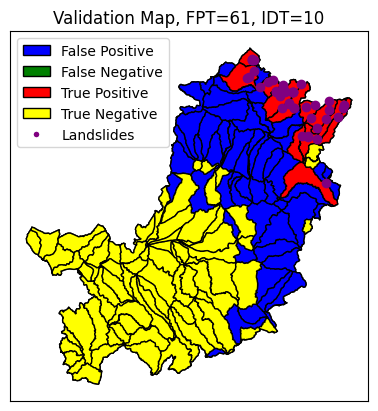

C:\Users\nicol\AppData\Local\Temp\ipykernel_58520\1059457376.py:51: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative


<Figure size 300x300 with 0 Axes>

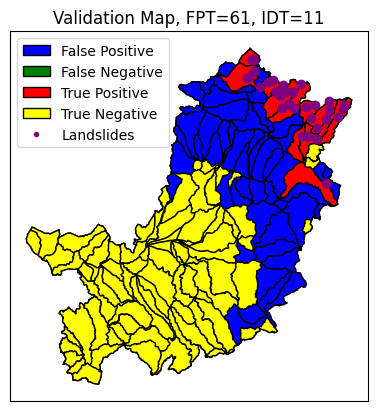

KeyboardInterrupt: 

In [ ]:
# Initialize the confusion matrix for storing results
matrix = np.zeros((len(idt), 6))

for FPT in fpt:
    for k, IDT in enumerate(idt):
        
        for ii in range(len(PAUs)):
            masked_Raster, masked_transform = mask.mask(Raster, [PAUs.geometry.iloc[ii]], crop=True, nodata=np.nan) # masked_Raster = identify pixels inside each PAU
            
            total_pixels = np.count_nonzero(~np.isnan(masked_Raster))  # Total number of pixels for masked_raster
            A = (masked_Raster >= FPT).sum()  # Total number of such pixels with landslide probability values greater than FPT
            #A = (masked_Raster <= FPT).sum() # When FPT is expressed in terms of safety factor
            B = (A / total_pixels) * 100  # Percentage of pixels with values greater than FPT
  
            # Check for each PAUs if the amount of unstable pixel is greater than IDT
            if B >= IDT: # use "A >= IDT:" if you expressed IDT in terms of number of pixels
                if PAUs.loc[ii, 'DepVar'] == 1:
                    PAUs.loc[ii, 'prediction'] = "TP" # If a landslide is reported for the selected PAU and the unstable pixel
                    # amount exceeds the IDT, the landslide event is correctly predicted by the model (True Positive, TP).
                else:
                    PAUs.loc[ii, 'prediction'] = "FP" # If no landslides are reported but the unstable pixel amount exceeds the
                    # IDT, a false alarm is issued (False Positive, FP).
            else:
                if PAUs.loc[ii, 'DepVar'] == 1:
                    PAUs.loc[ii, 'prediction'] = "FN" # If a landslide is reported for the selected PAU but the unstable pixel
                    # amount does not exceed the IDT, the landslide event is missed by the model (False Negative, FN).
                else:
                    PAUs.loc[ii, 'prediction'] = "TN" # If no landslides are reported and the unstable pixel amount does not
                    # exceed the IDT, no alert is issued (True Negative, TN).
        
        # Compute the confusion matrix
        predictions = PAUs['prediction']
        matrix[k, 0] = FPT 
        matrix[k, 1] = IDT
        matrix[k, 2] = np.count_nonzero(predictions == 'TP')
        matrix[k, 3] = np.count_nonzero(predictions == 'FN')
        matrix[k, 4] = np.count_nonzero(predictions == 'FP')
        matrix[k, 5] = np.count_nonzero(predictions == 'TN')
        
        # Plot the validation map
        plt.figure(figsize=(3, 3))
        ax=PAUs.plot(color="none", edgecolor="black")
        plt.title(f'Validation Map, FPT={int(FPT*100)}, IDT={int(IDT)}') # use (FPT*100) if FPT is expressed in landslide probability values between 0 and 1
        attribute_value = "FP"
        FP = PAUs[PAUs['prediction'] == attribute_value]
        legend_FP = Patch(facecolor='blue', edgecolor='black', label='False Positive')
        cx=FP.plot(ax=ax, color="blue", edgecolor="black") # BLUE = False Positive
        attribute_value = "FN"
        FN = PAUs[PAUs['prediction'] == attribute_value]
        legend_FN = Patch(facecolor='green', edgecolor='black', label='False Negative')
        dx=FN.plot(ax=ax, color="green", edgecolor="black") # GREEN = False Negative
        attribute_value = "TP"
        TP = PAUs[PAUs['prediction'] == attribute_value]
        legend_TP = Patch(facecolor='red', edgecolor='black', label='True Positive')
        ex=TP.plot(ax=ax, color="red", edgecolor="black") # RED = True Positive
        attribute_value = "TN"
        TN = PAUs[PAUs['prediction'] == attribute_value]
        legend_TN = Patch(facecolor='yellow', edgecolor='black', label='True Negative')
        fx=TN.plot(ax=ax, color="yellow", edgecolor="black") # YELLOW = True Negative
        bx=filtered_landslides.plot(ax=ax, color='purple')
        ax.legend(handles=[legend_FP, legend_FN, legend_TP, legend_TN, legend_landslides], loc='upper left')
        plt.xticks([])
        plt.yticks([])
        # Save the plot as .jpg
        filename2=(f'insert_your_path\Vmap_example_{int(FPT*100)}_{int(IDT)}.jpg')
        plt.savefig(filename2)
        plt.show()

        # Save the updated PAUs shapefile, it represents the PAUs-based validation map
        filename=(f'insert_your_path\Vmap_example_{int(FPT*100)}_{int(IDT)}.shp')
        warnings.filterwarnings("ignore", message="Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.")
        PAUs.to_file(filename)

    # Save the confusion matrix for each FPT value to an Excel file
    filename3=(f'insert_your_path\conf_mat_example_{int(FPT*100)}.xlsx')
    CONF_MATRIX = pd.DataFrame(matrix, columns=['FPT','IDT','TP', 'FN', 'FP', 'TN'])
    CONF_MATRIX.to_excel(filename3)
    # Print the resulting confusion matrix
    print(CONF_MATRIX)
    print('-'*50)

====================================================================================================
#### **6) Calculate the main statistical metrics to evaluate the performance of each validation map**

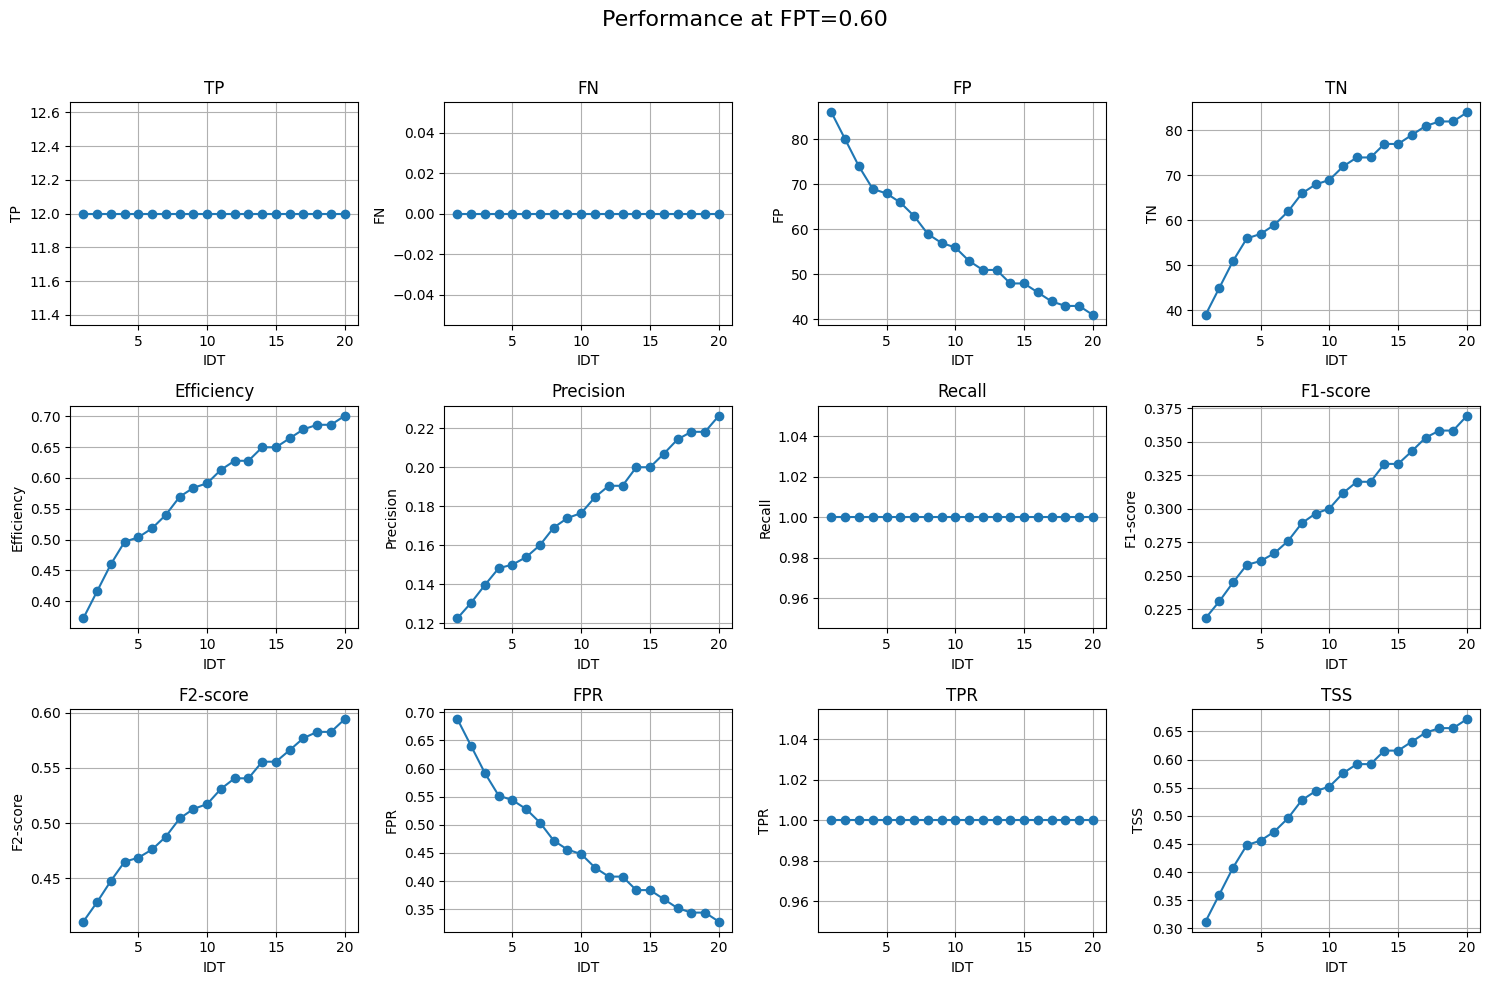

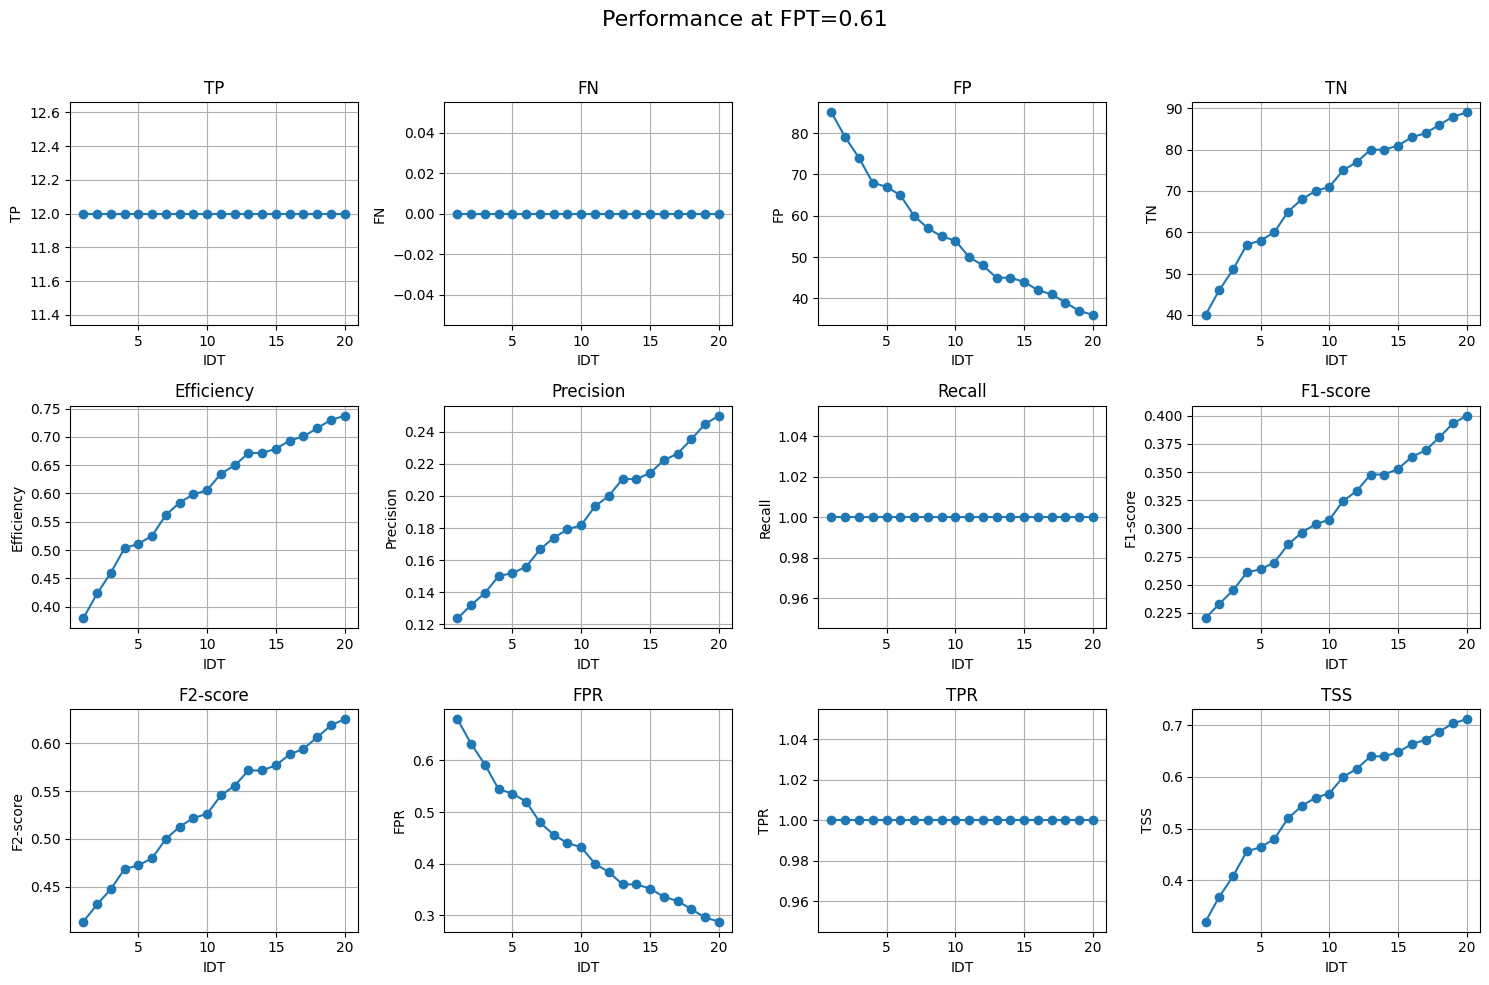

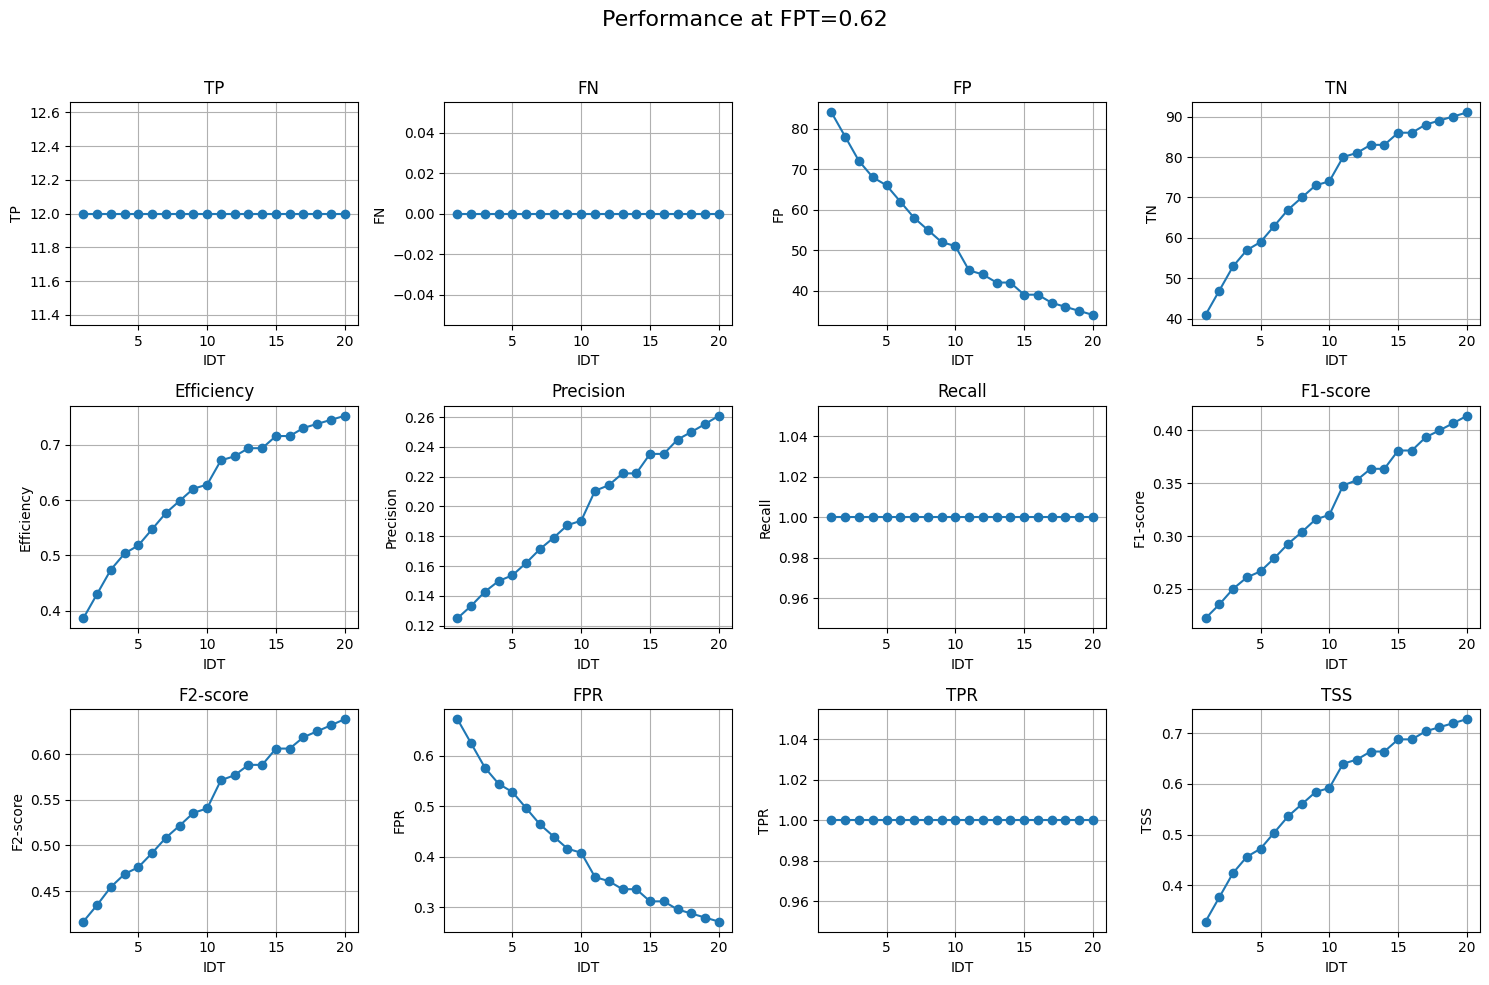

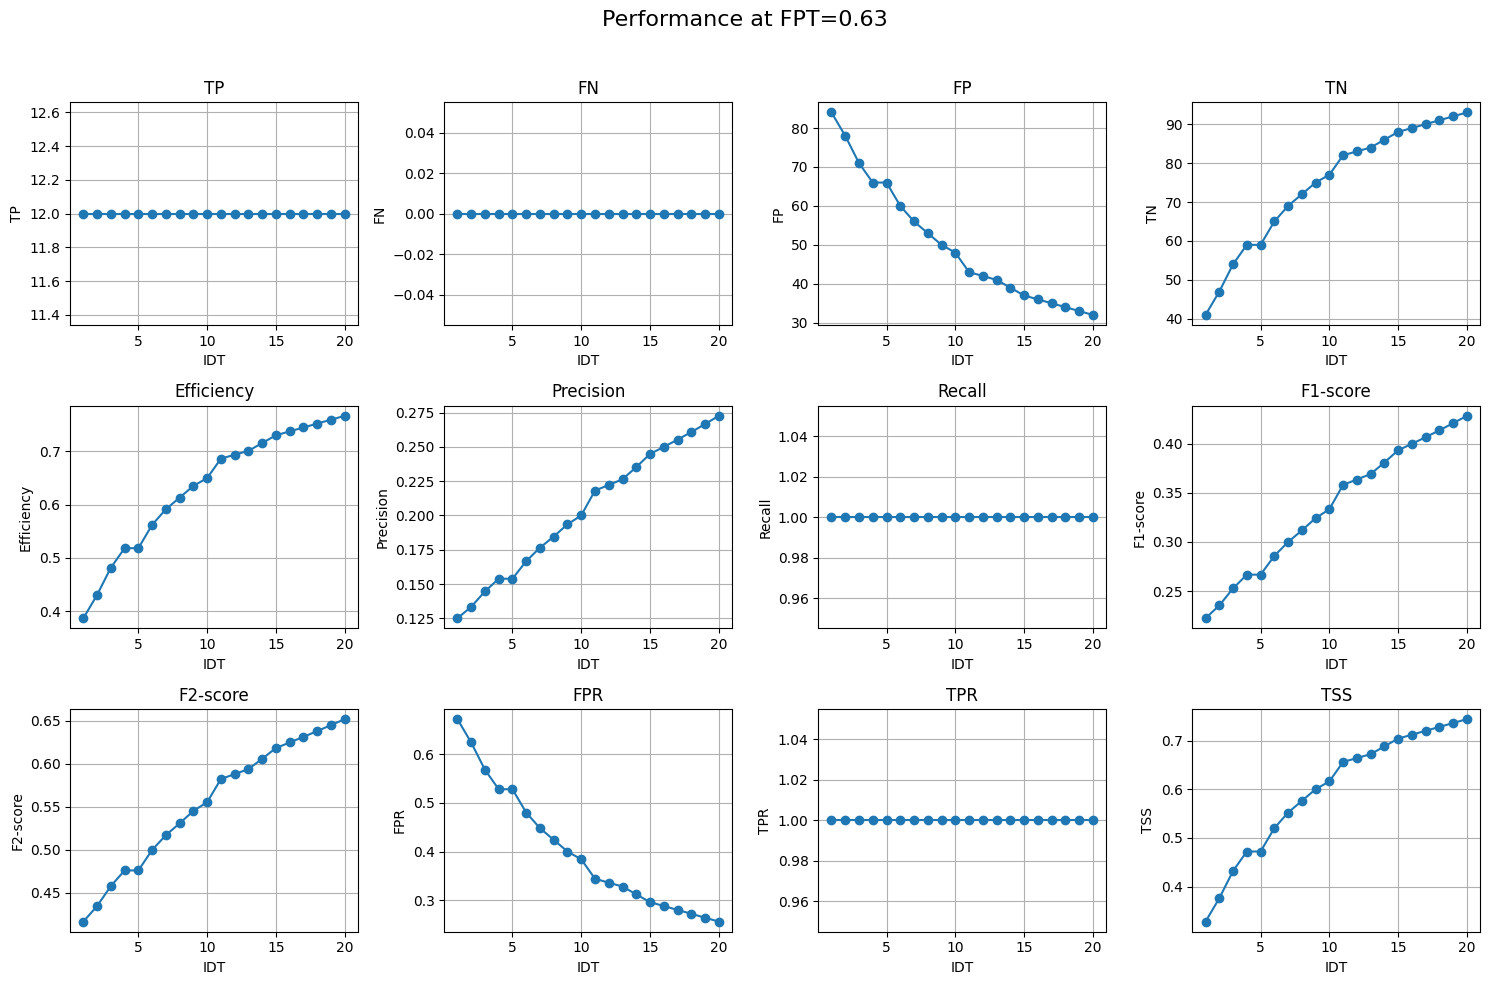

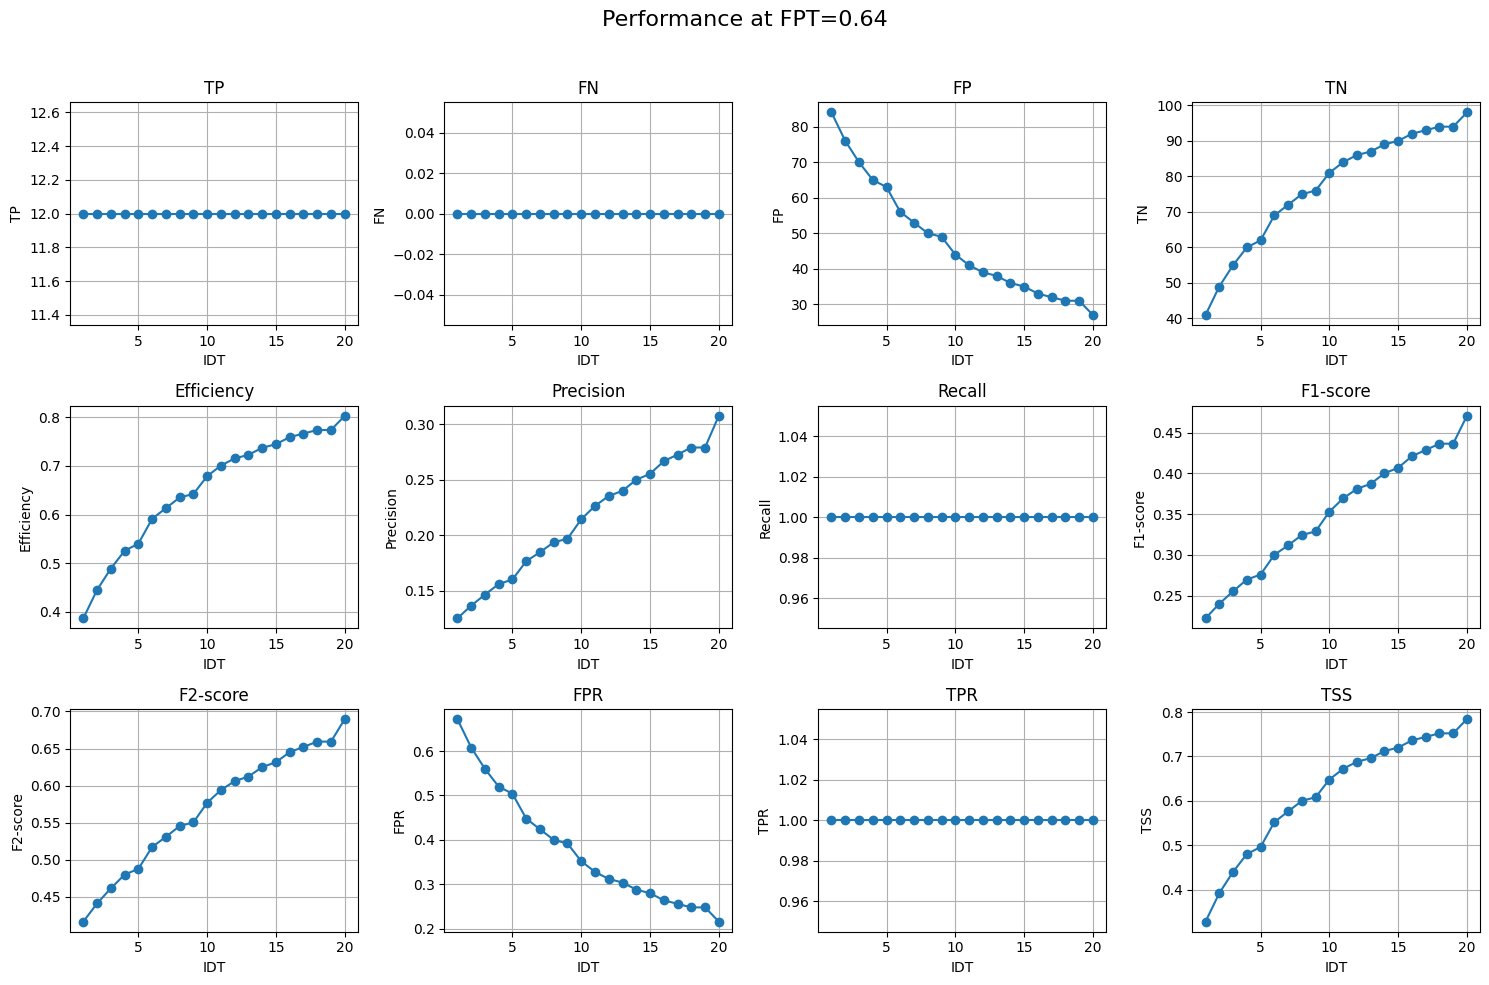

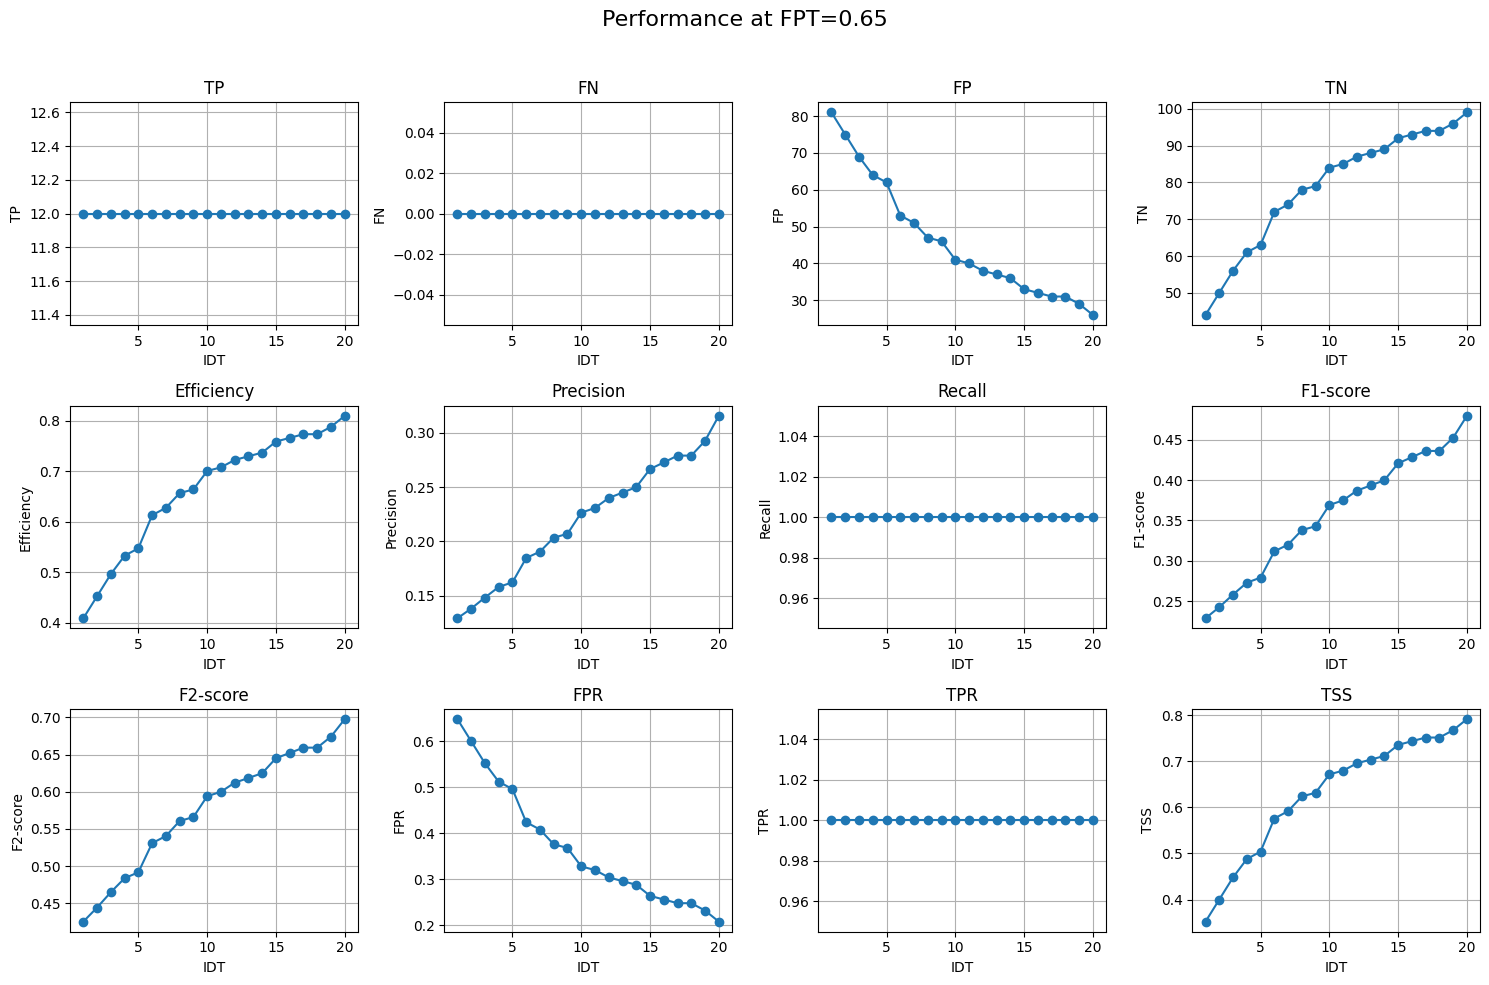

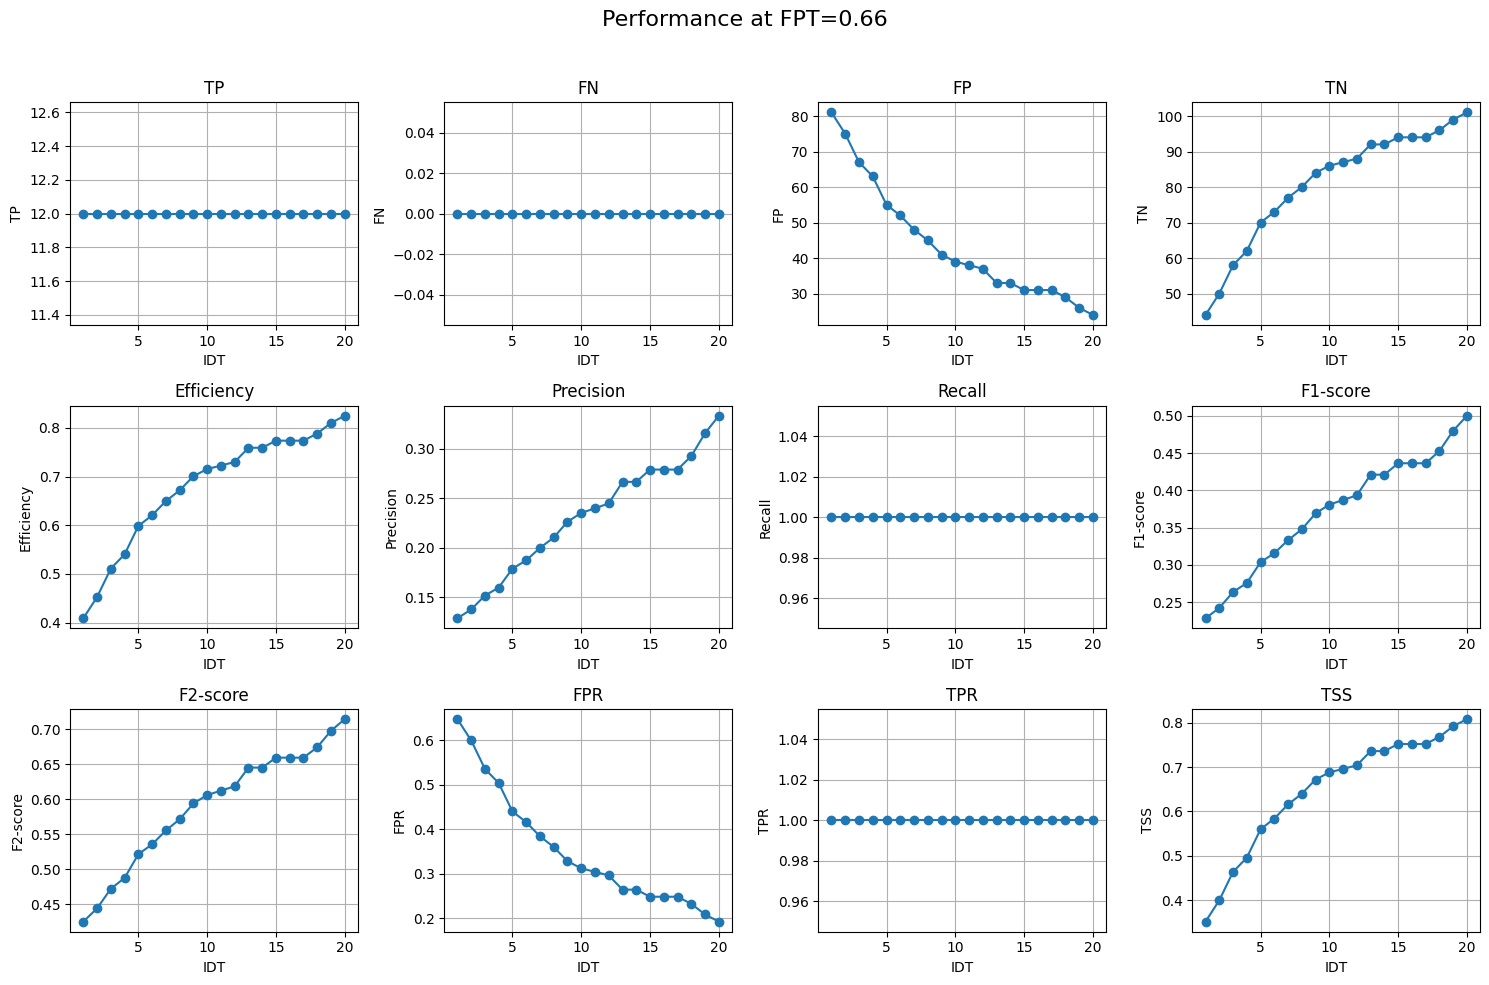

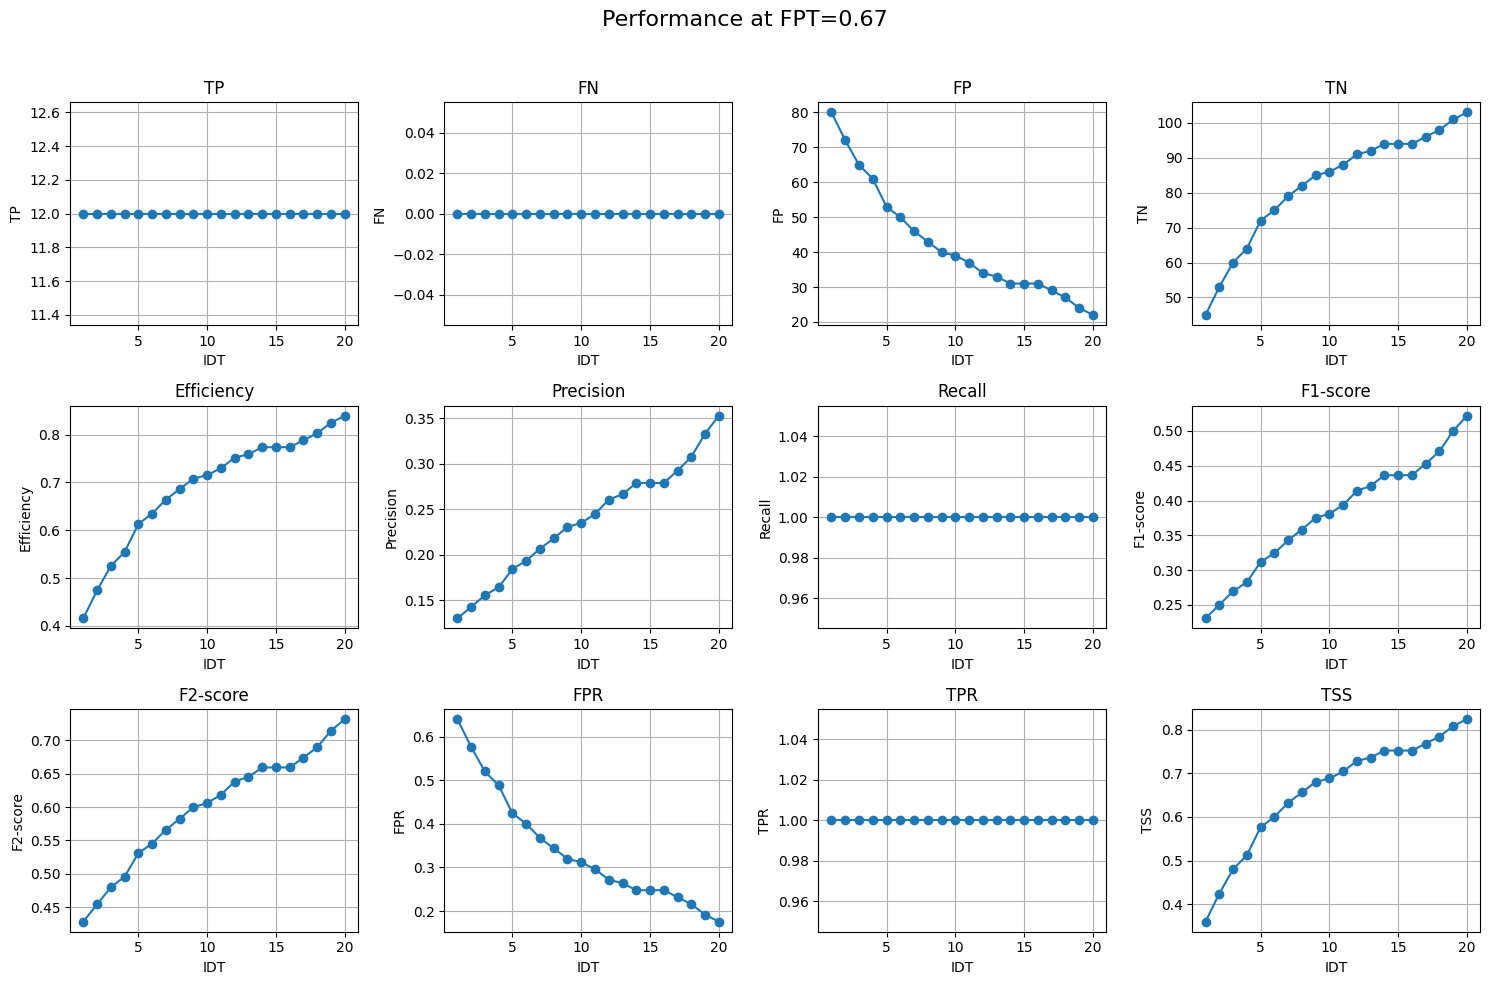

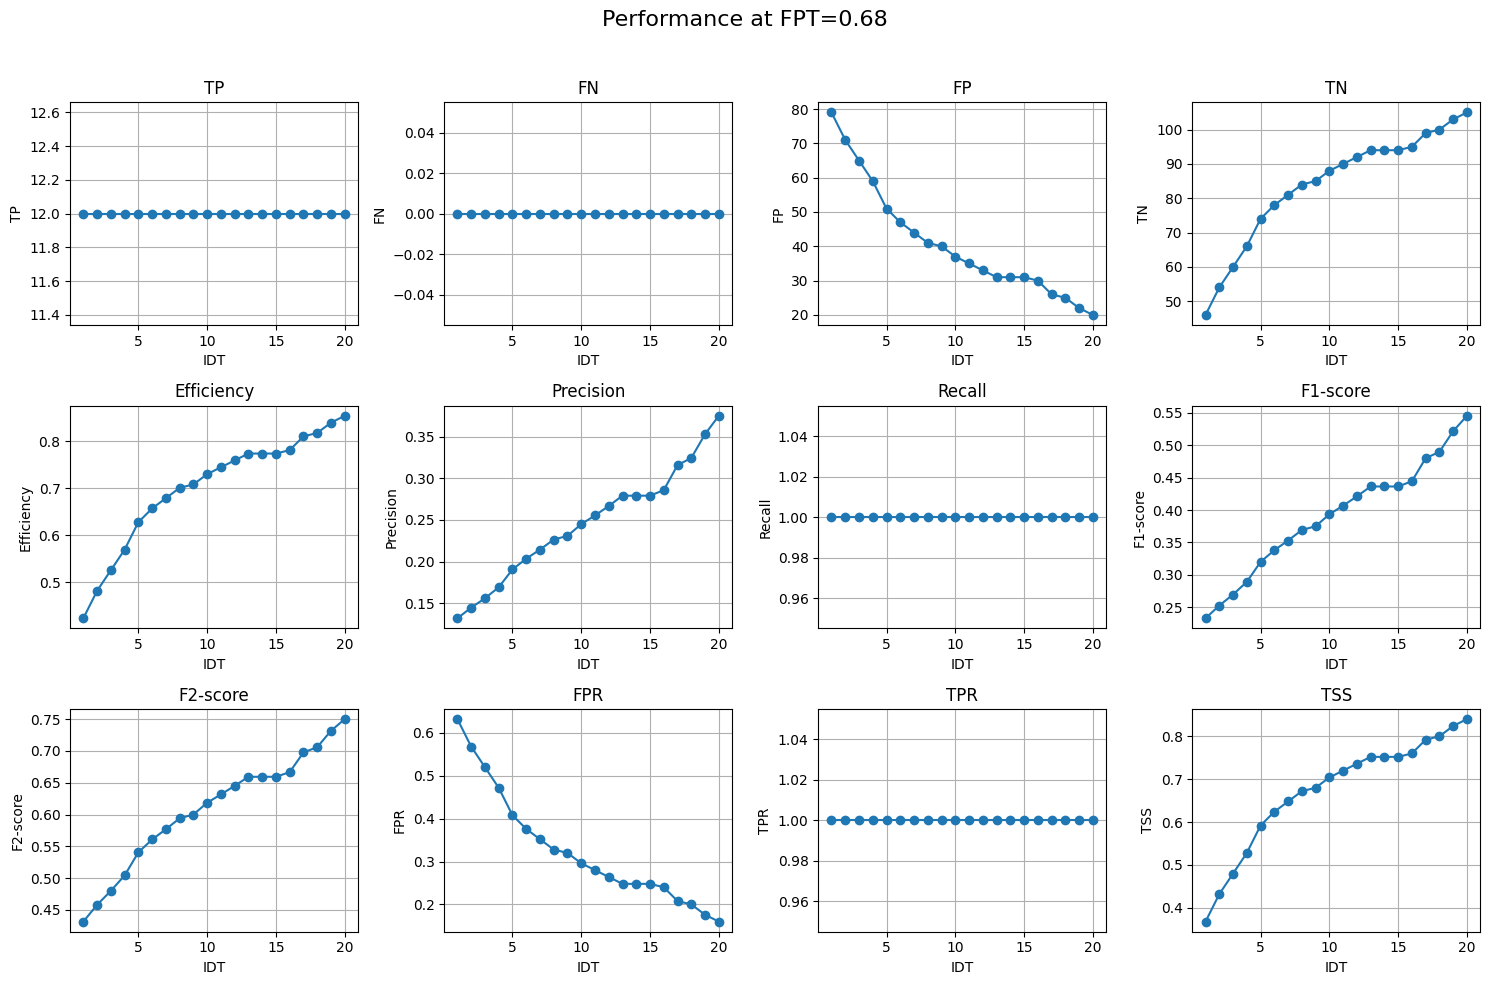

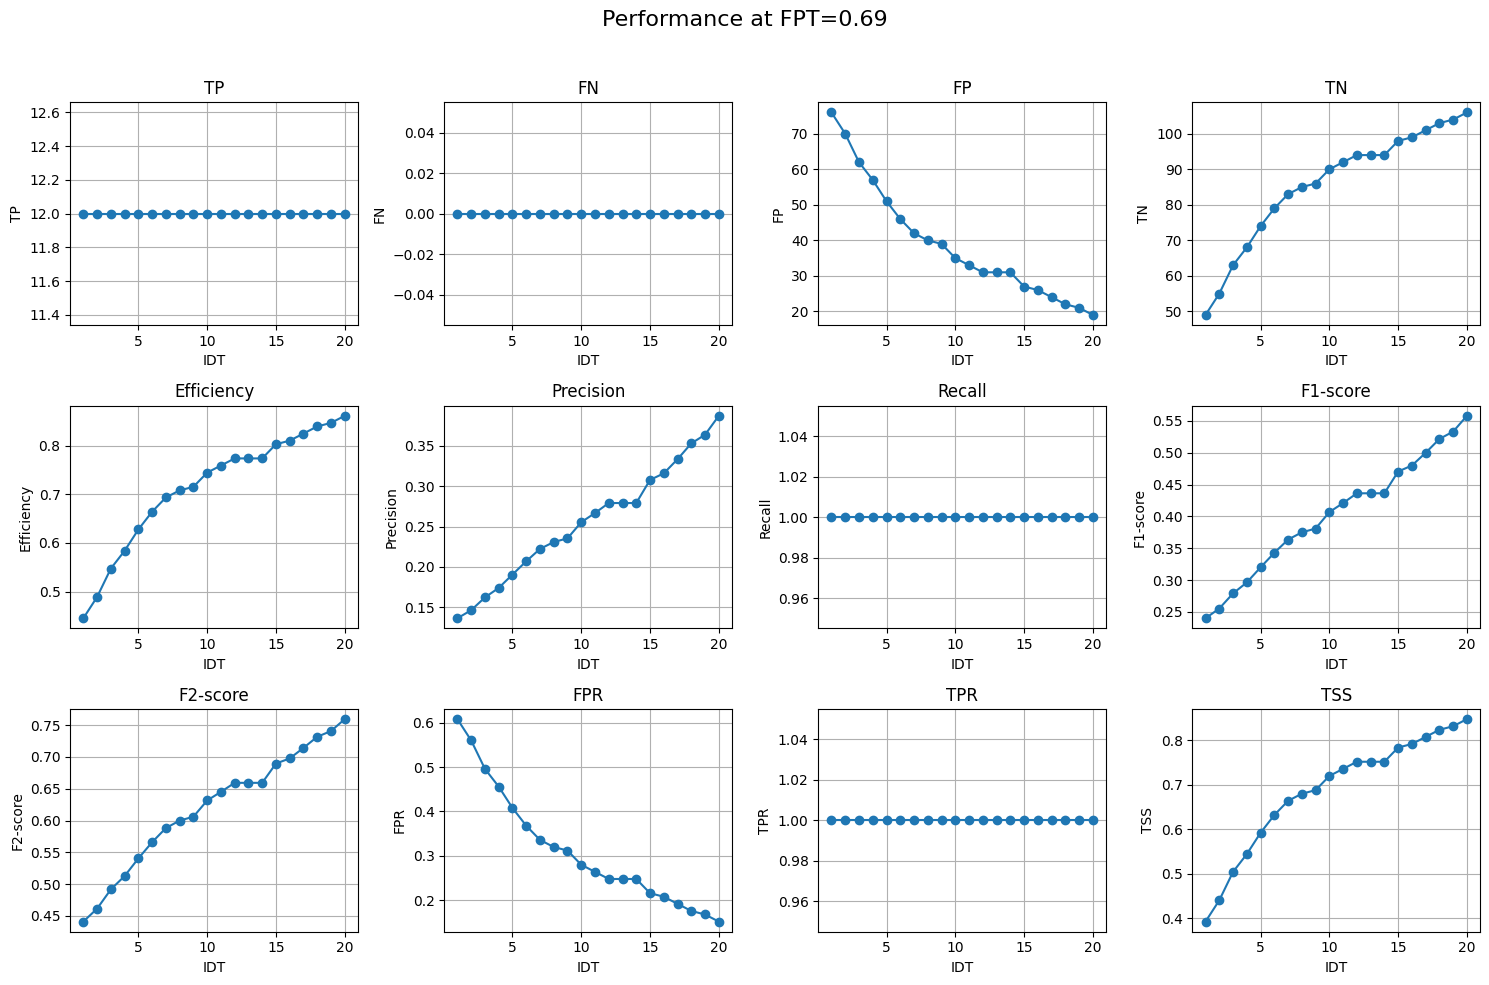

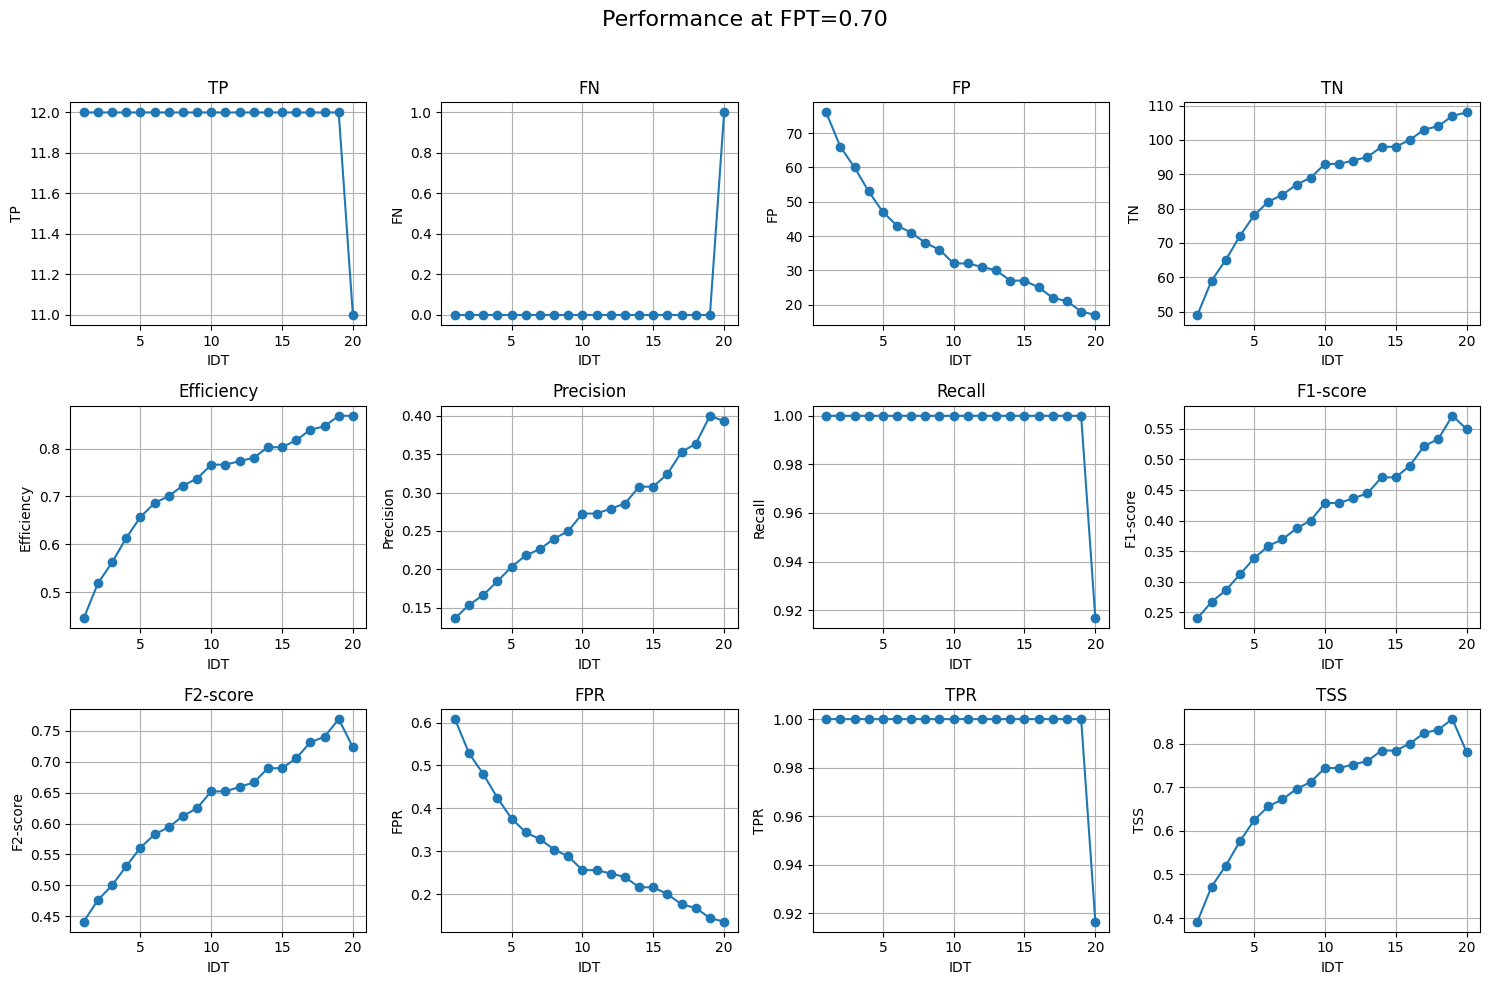

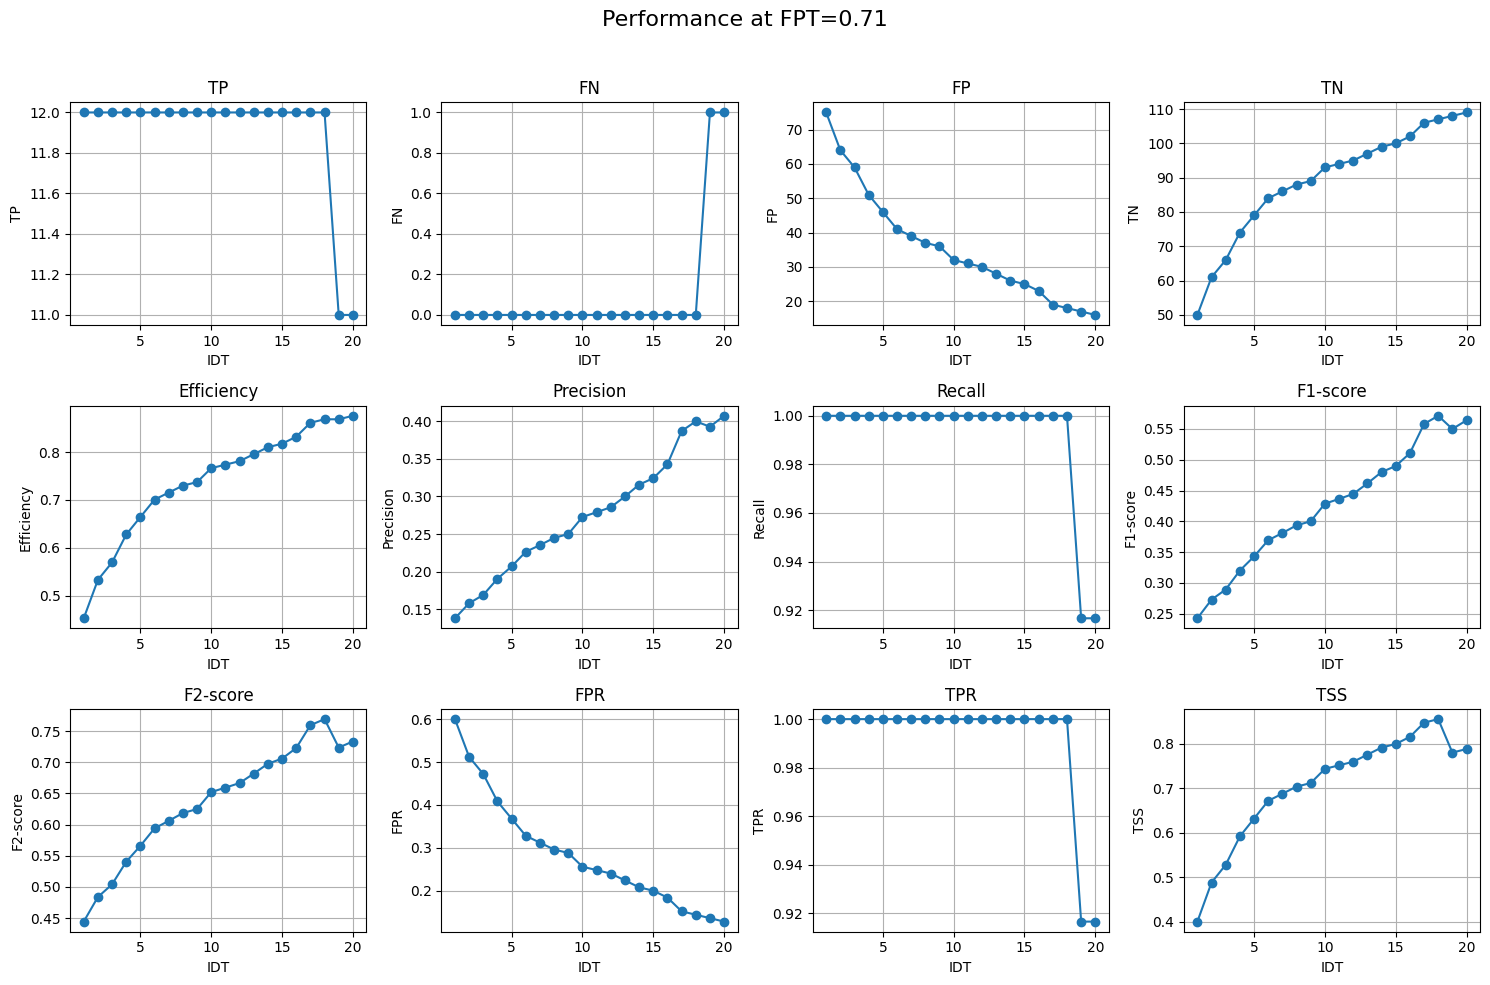

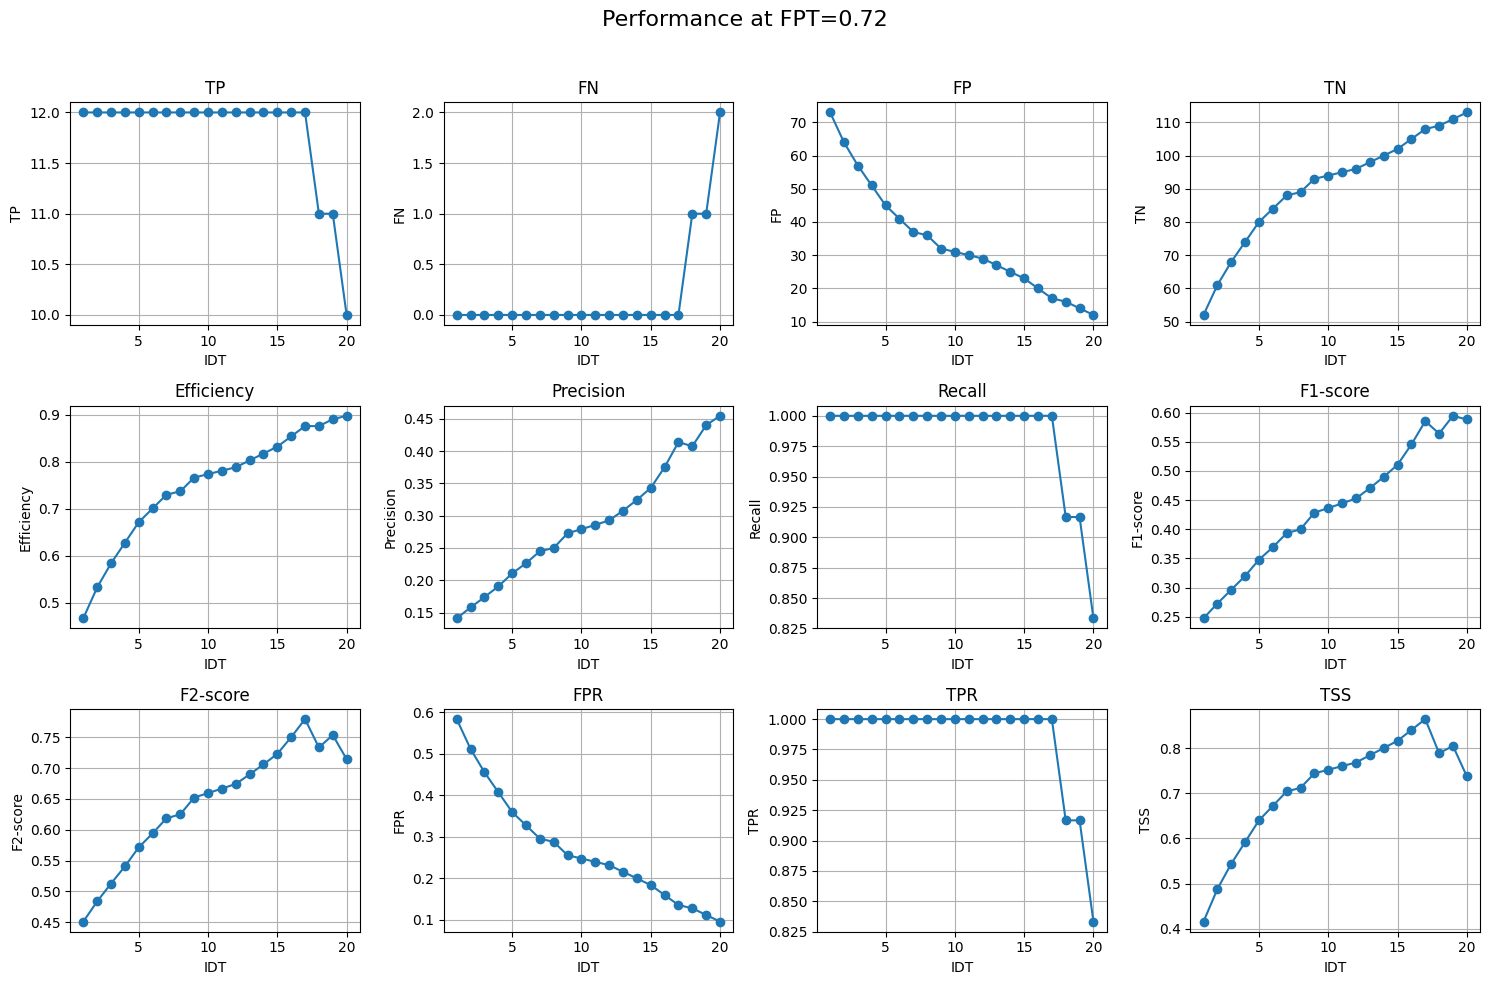

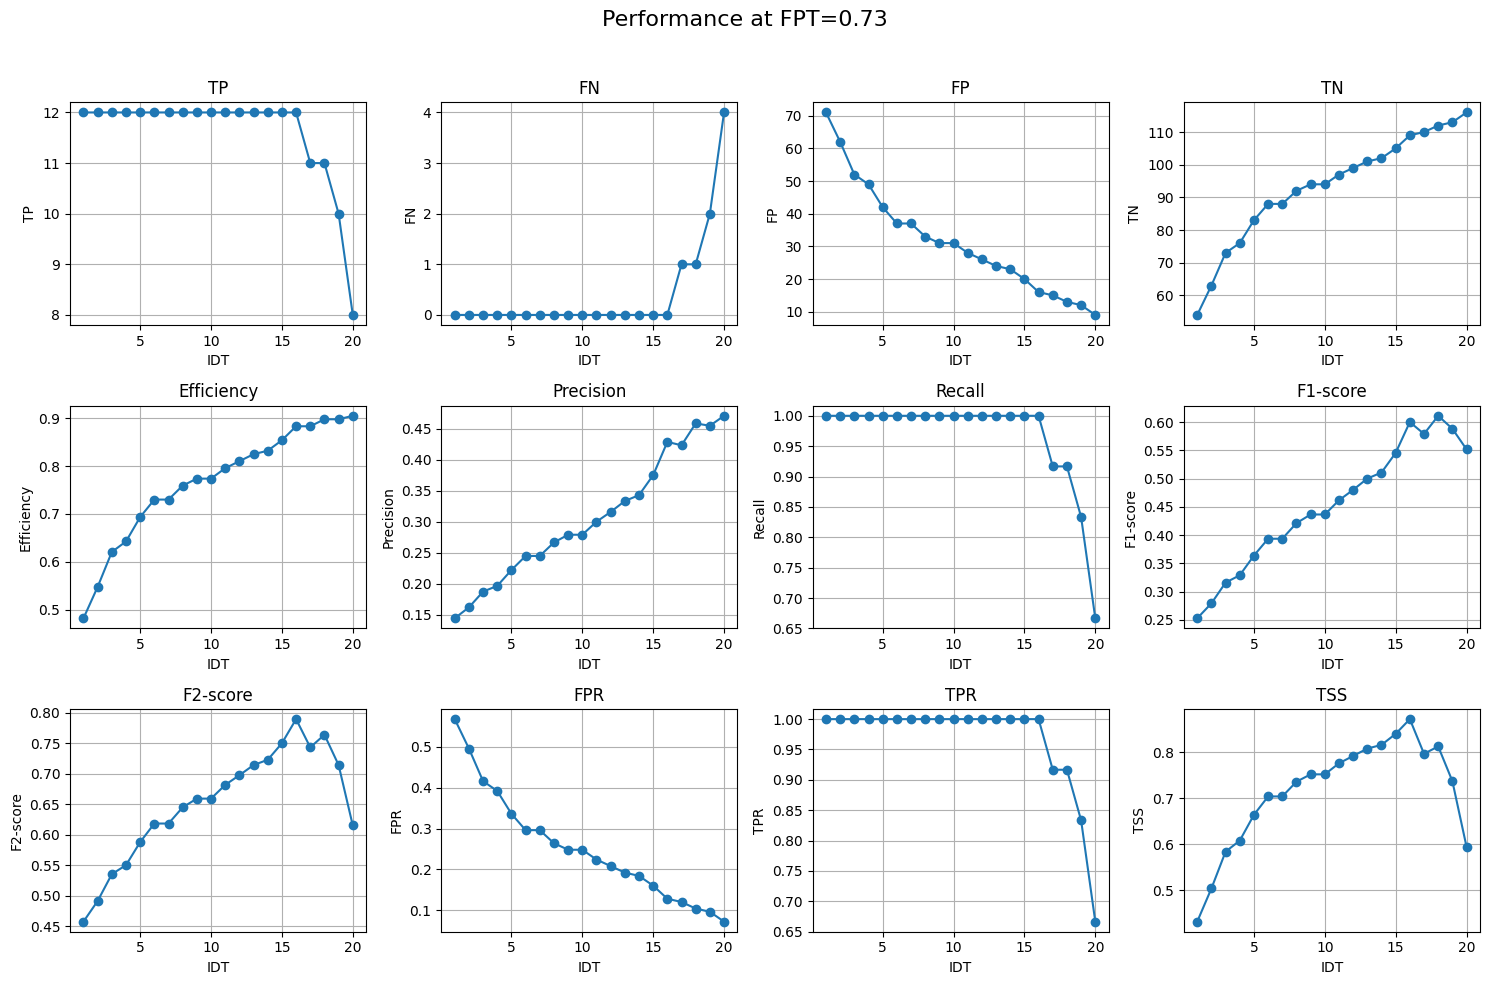

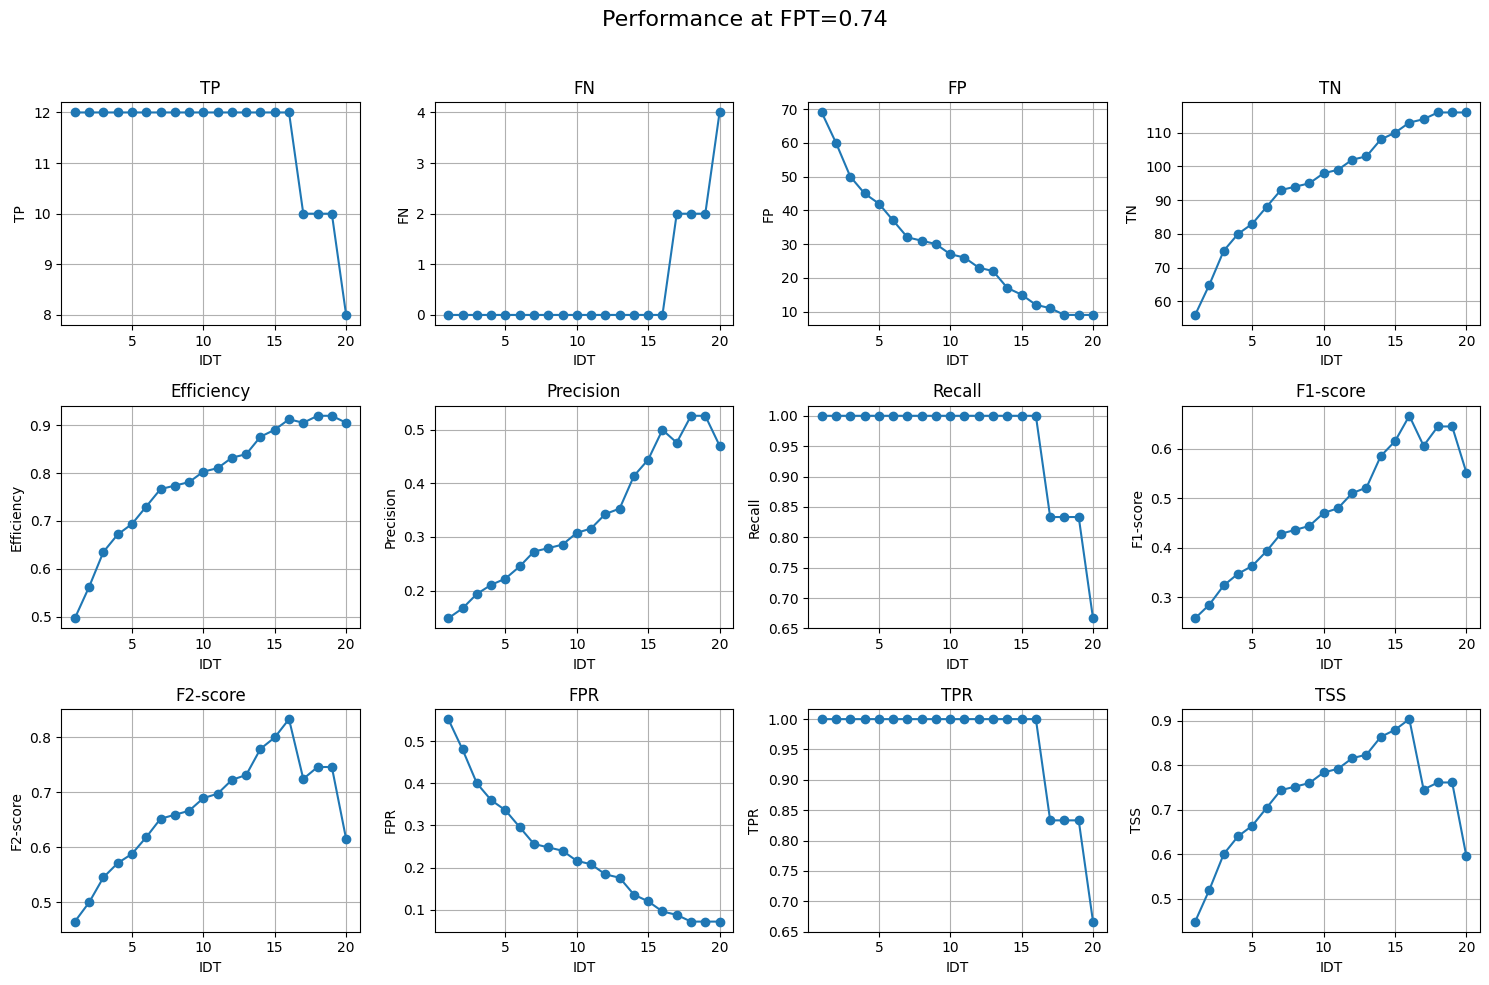

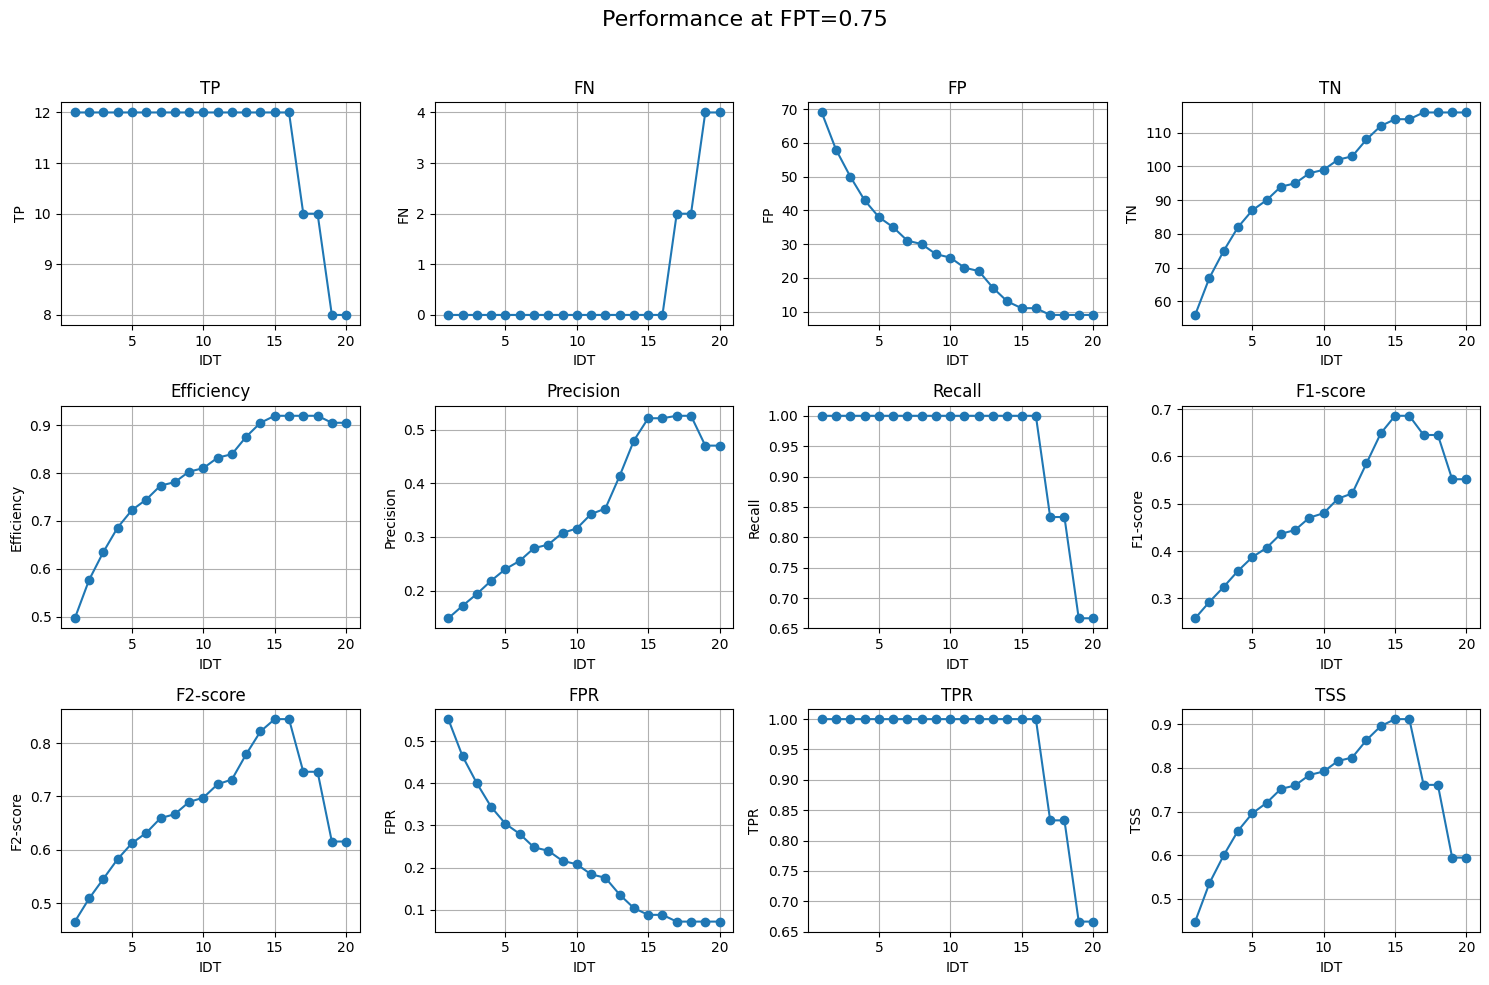

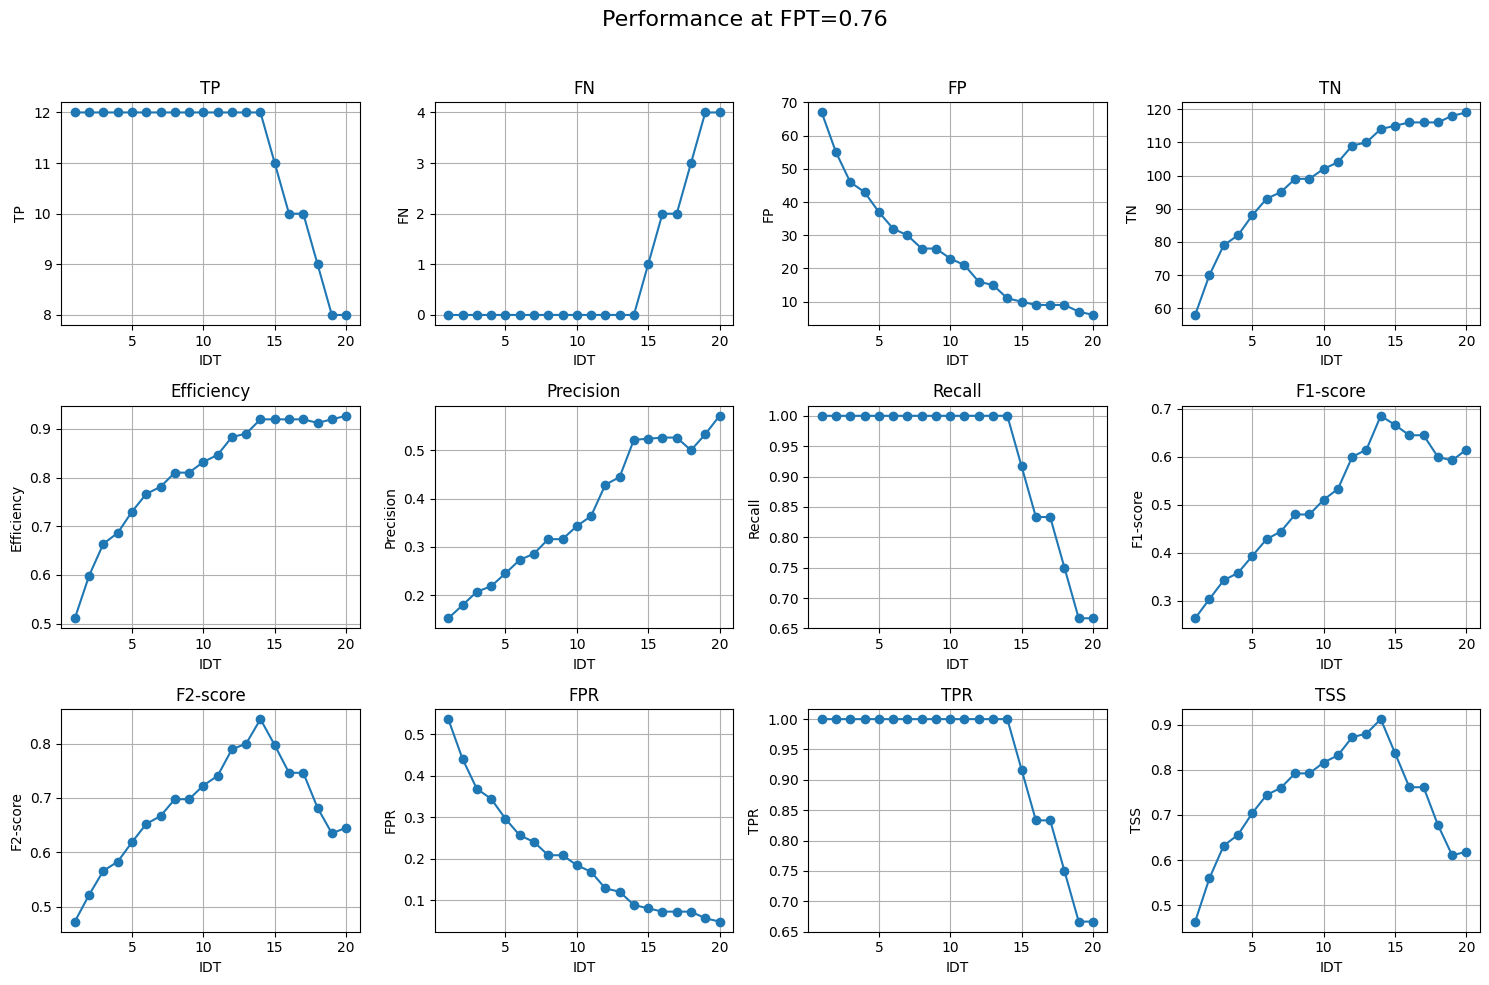

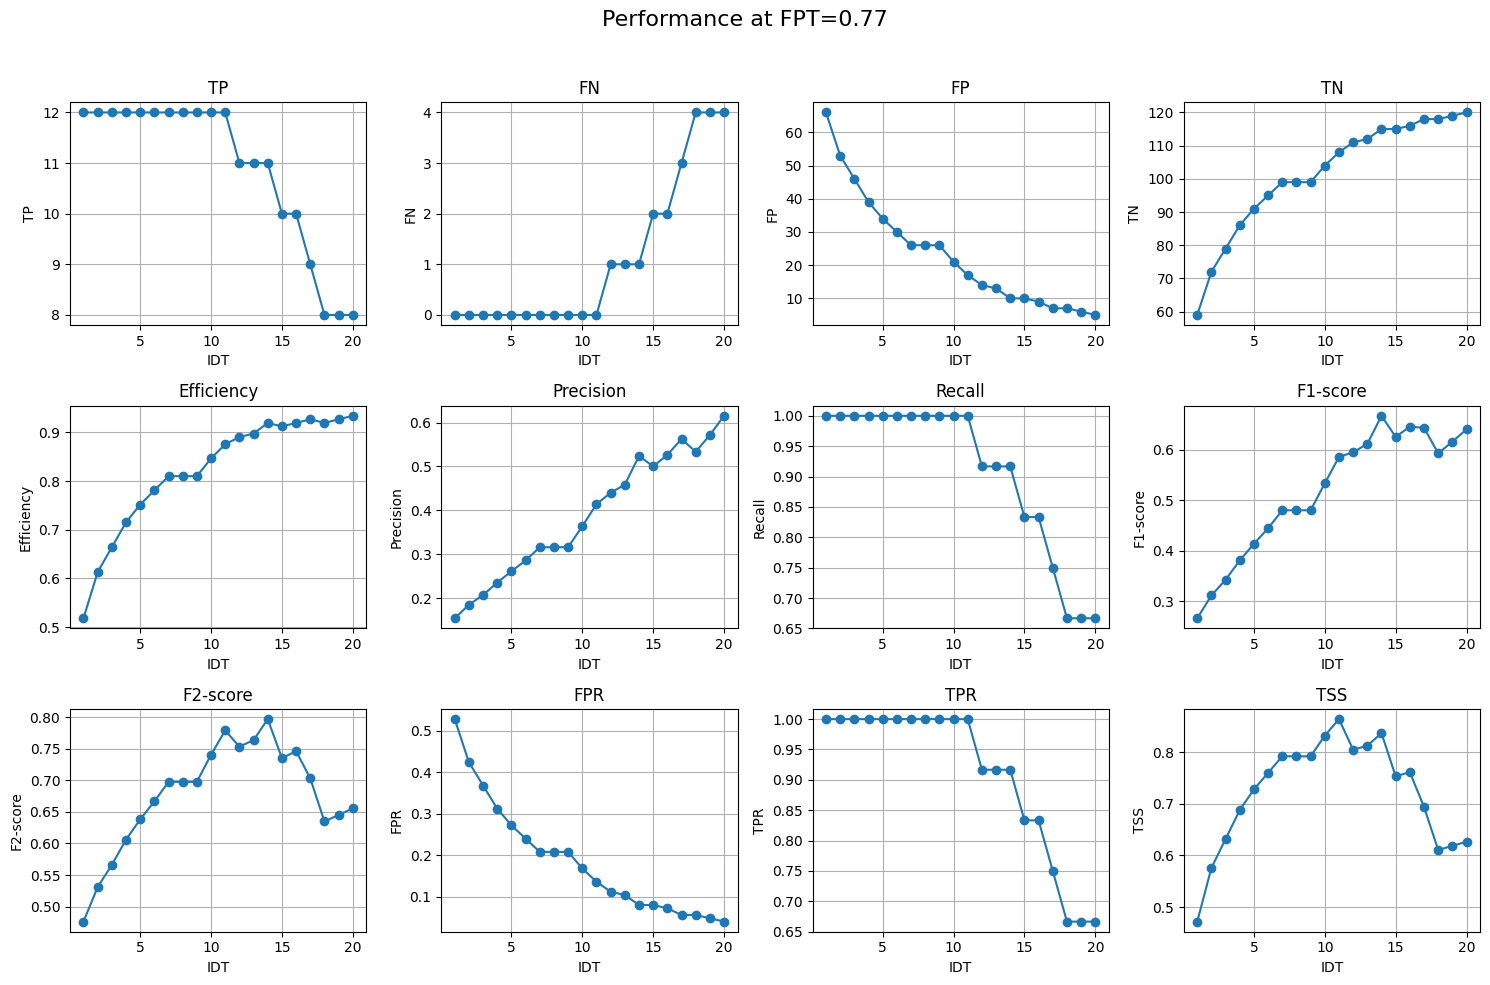

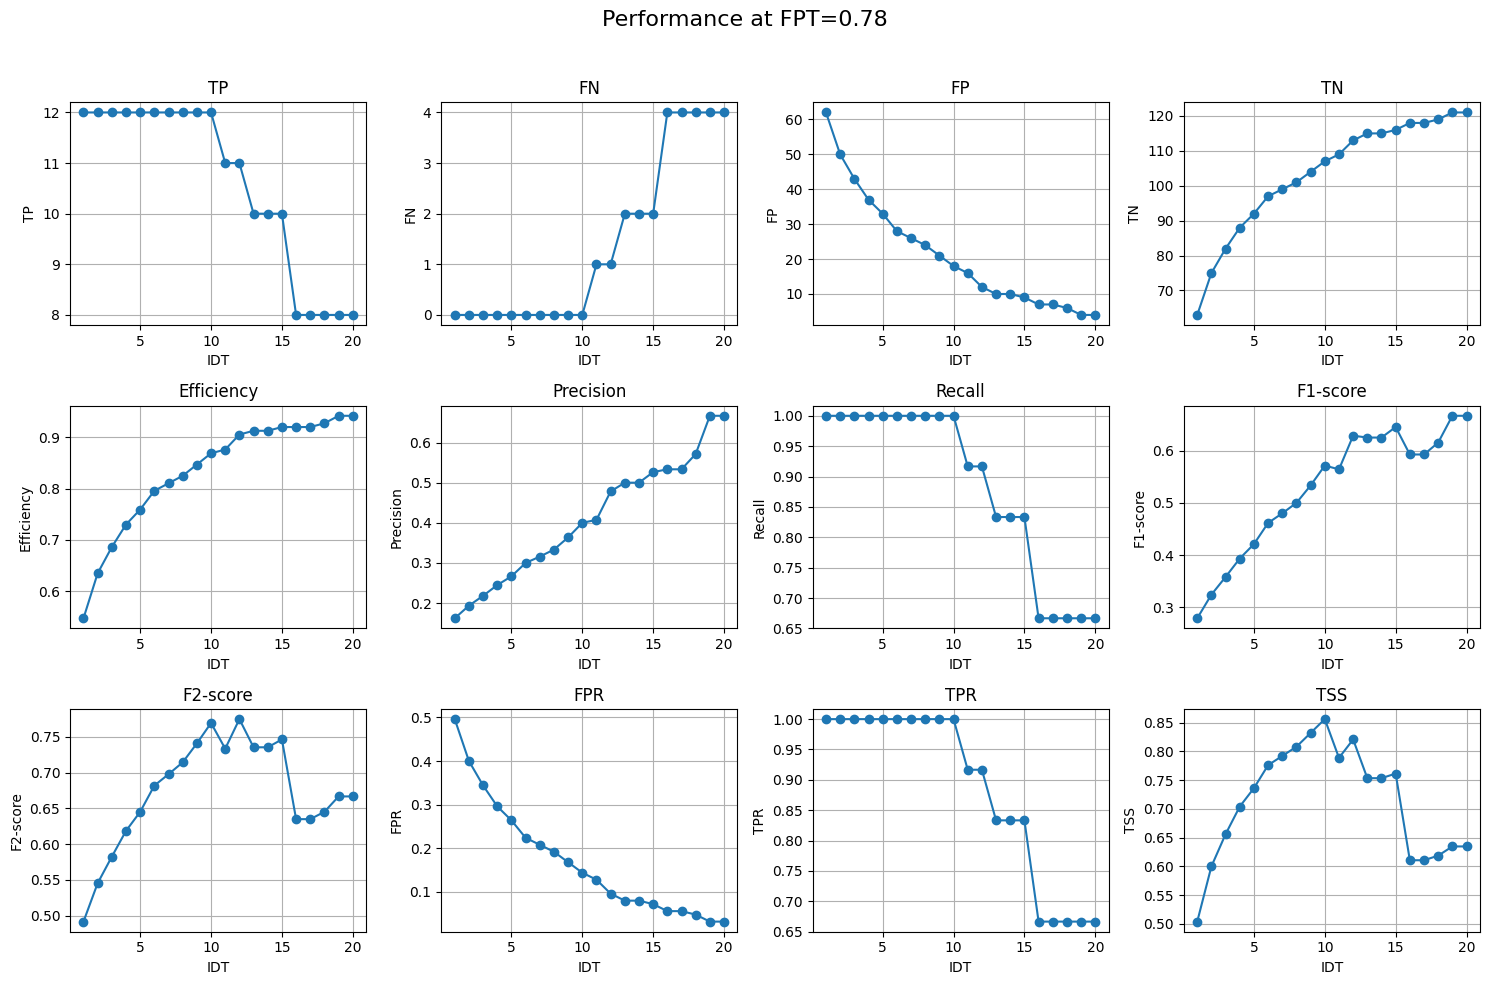

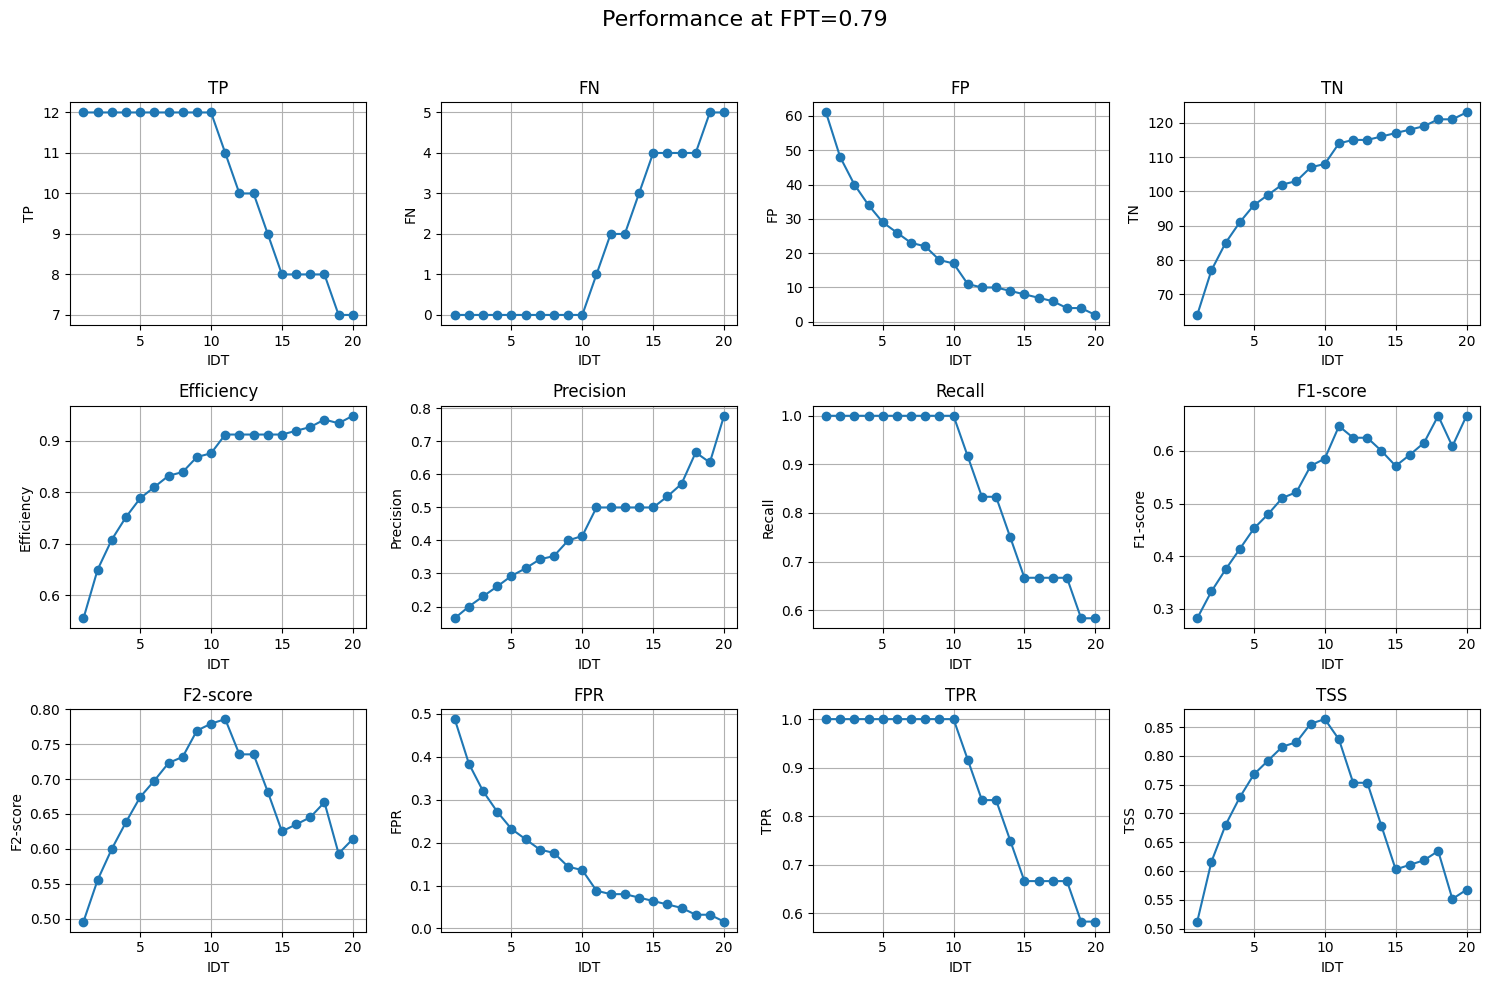

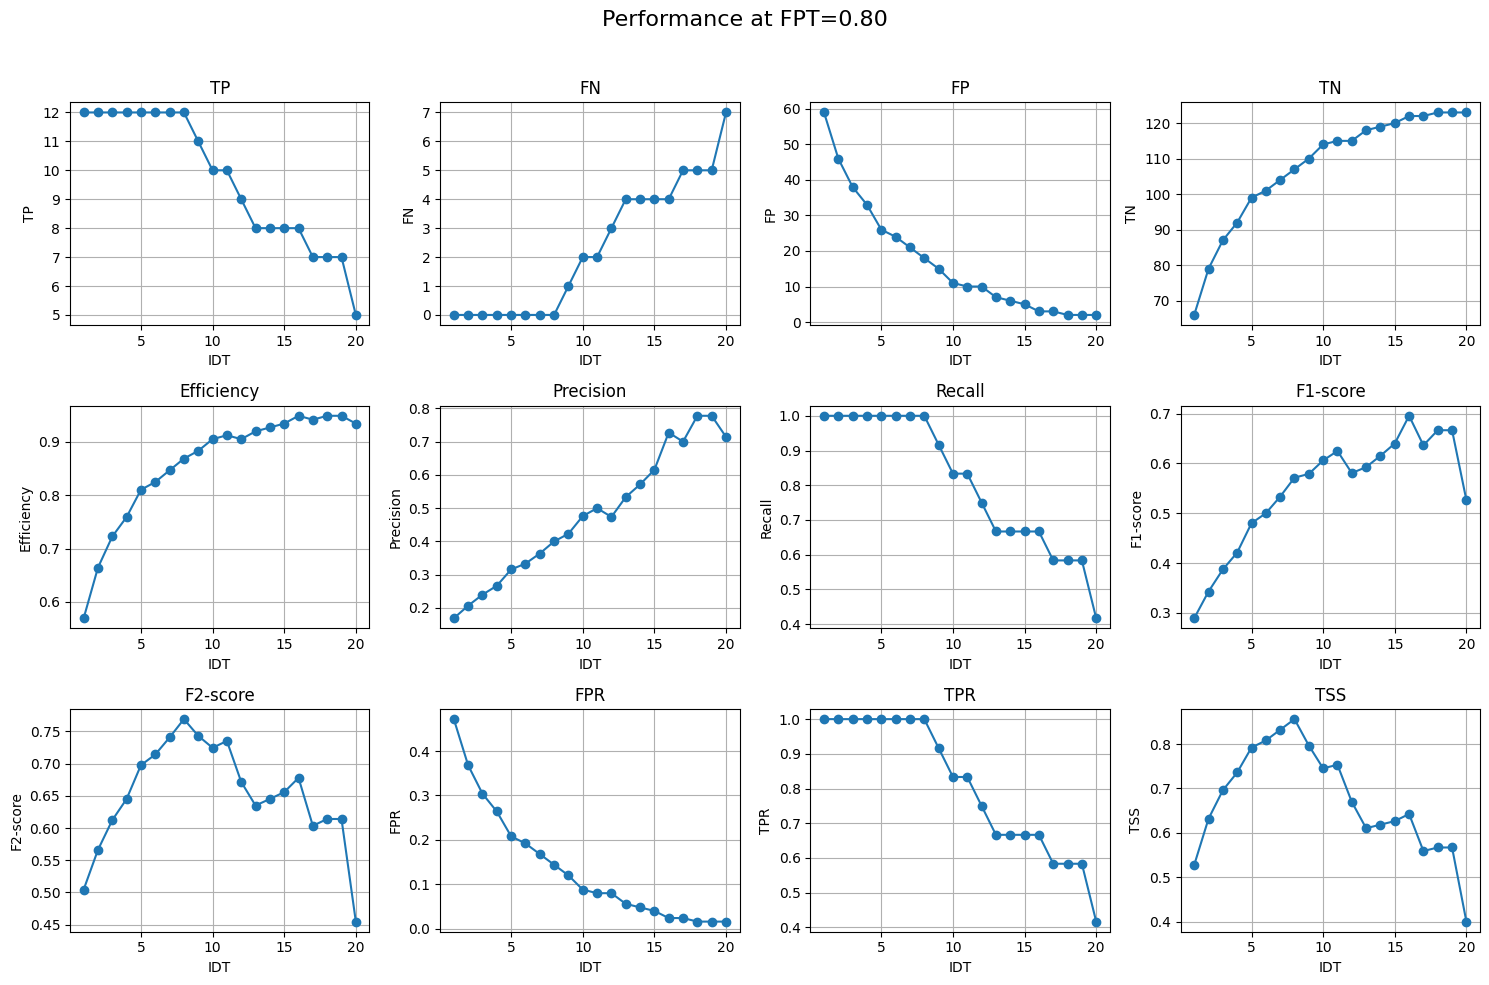

In [ ]:
for FPT in fpt:
    # Specify the path of the contingency matrix file
    df = pd.read_excel(f'insert_your_path\conf_mat_example_{int(FPT*100)}.xlsx')

    # Efficiency
    df['Efficiency'] = (df['TP'] + df['TN']) / (df['TP'] + df['FN'] + df['FP'] + df['TN'])
    # Precision
    df['Precision'] = df['TP'] / (df['TP'] + df['FP'])
    # Recall
    df['Recall'] = df['TP'] / (df['TP'] + df['FN'])
    # F1-score
    df['F1-score'] = 2 * (df['Precision'] * df['Recall']) / (df['Precision'] + df['Recall'])
    # F2-score
    beta = 2
    df['F2-score'] = (1 + (beta ** 2)) * (df['Precision'] * df['Recall']) / ((beta ** 2) * df['Precision'] + df['Recall'])
    # False Positive Rate
    df['FPR'] = (df['FP'] / (df['FP'] + df['TN']))
    # True Positive Rate
    df['TPR'] = (df['TP'] / (df['TP'] + df['FN']))
    # True Skill Statistic
    df['TSS'] = (df['TPR'] - df['FPR'])

    # Plot each statistical metric (specified FPT and each IDT)
    columns_to_plot = ['TP', 'FN', 'FP', 'TN', 'Efficiency', 'Precision', 'Recall', 'F1-score', 'F2-score', 'FPR', 'TPR', 'TSS']
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
    fig.suptitle(f'Performance at FPT={float(FPT):.2f}', fontsize=16)

    for i, column in enumerate(columns_to_plot):
        row = i // 4
        col = i % 4

        axs[row, col].plot(df['IDT'], df[column], marker='o')
        axs[row, col].set_title(column)
        axs[row, col].set_xlabel('IDT')
        axs[row, col].set_ylabel(column)
        axs[row, col].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Save the subplot
    plt.savefig(f'insert_your_path\performance_example_{int(FPT*100)}.tif')
    plt.show()  

    # Save the updated contingency matrix
    df.to_excel(f'insert_your_path\conf_mat_example{int(FPT*100)}.xlsx', index=False)
